In [6]:
# -*- coding: utf-8 -*-
#%% Imports
import pandas as pd
import numpy as np
import sklearn
import matplotlib
from matplotlib import pyplot as plt
import warnings
from nltk.stem import PorterStemmer
from nltk import word_tokenize, sent_tokenize
from sklearn.manifold import TSNE
from time import clock
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans as kmeans
from sklearn.mixture import GaussianMixture as GMM
from collections import defaultdict
from helpers import cluster_acc, reconstructionError
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import ShuffleSplit, StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import validation_curve
import sklearn_evaluation 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_mutual_info_score, pairwise
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection
import random
import sys
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1)
get_ipython().run_line_magic('matplotlib', 'inline')
warnings.filterwarnings("ignore")

N_ROWS = 10000
N_FEATURES = 500
RANDOM_SEED = 10

In [7]:
wine_red = pd.read_csv('winequality-red.csv',sep=';')
wine_white = pd.read_csv('winequality-white.csv',sep=';')
wine_data = pd.concat([wine_red, wine_white])
wine_data = wine_data.sample(frac=1, random_state = RANDOM_SEED).reset_index(drop=True)
wine_data['quality'][wine_data['quality']<7] = 0
wine_data['quality'][wine_data['quality']>=7] = 1
wine_quality = wine_data['quality']

#del wine_data['quality']

In [8]:
wine_data.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0  6.8            0.18              0.35         5.40            0.054       
1  7.7            0.17              0.52         5.90            0.017       
2  7.1            0.17              0.40         14.55           0.047       
3  6.0            0.33              0.20         1.80            0.031       
4  7.1            0.67              0.00         2.30            0.083       

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0  53.0                 143.0                 0.99287  3.10  0.54        
1  21.0                 84.0                  0.99290  3.14  0.40        
2  47.0                 156.0                 0.99945  3.34  0.78        
3  49.0                 159.0                 0.99190  3.41  0.53        
4  18.0                 27.0                  0.99768  3.44  0.54        

   alcohol  quality  
0  11.0     1        
1  11.9     1        
2  9.1      0        
3  11.0     0        
4  9.4      0

In [9]:
y_labels = wine_quality
wine_train = wine_data.iloc[0:4000,:]
wine_valid = wine_data.iloc[4000:5000,:]
wine_test = wine_data.iloc[5000:6400,:]

x_data = StandardScaler().fit_transform(wine_data.iloc[:,:-1])

x_train = x_data[0:4000,:]
x_valid =  x_data[4000:5000,:]
x_test =  x_data[5000:6400,:]

y_train = y_labels[0:4000]
y_valid = y_labels[4000:5000]
y_test = y_labels[5000:6400]

print("Train Rows:" + str(x_train.shape))
print("Train Labels:" + str(y_train.shape))
print("Validation Rows:" + str(x_valid.shape))
print("Validation Labels:" + str(y_valid.shape))
print("Test Rows:" + str(x_test.shape))
print("Test Labels" + str(y_test.shape))

Train Rows:(4000, 11)
Train Labels:(4000,)
Validation Rows:(1000, 11)
Validation Labels:(1000,)
Test Rows:(1400, 11)
Test Labels(1400,)


In [10]:
### PERFORMANCE OF K MEANS AND EM CLUSTERING WITH NUMBER OF CLUSTERS
clusters =  [2,3,5,8,10,12,14,16,18,20,25,30,35,40,50,60,75]
#clusters =  [2,3,5,8,10]

SSE = defaultdict(dict)
ll = defaultdict(dict)
bic = defaultdict(dict)
aic = defaultdict(dict)
silhoutte = defaultdict(dict)

km = kmeans(random_state=RANDOM_SEED, init ='k-means++')
gmm = GMM(random_state=RANDOM_SEED)

st = clock()
for k in clusters:
    km.set_params(n_clusters=k)
    gmm.set_params(n_components=k)
    km.fit(x_train )
    gmm.fit(x_train)
    SSE[k]['Wine'] = km.score(x_train)
    ll[k]['Wine'] = gmm.score(x_train)
    bic[k]['Wine'] = gmm.bic(x_train)  
    aic[k]['Wine'] = gmm.aic(x_train)   

    print(k, clock()-st, SSE[k]['Wine'], ll[k]['Wine']
          , bic[k]['Wine'],aic[k]['Wine'])
    

2 0.10963900000000004 -34832.794287797195 -10.952135922566589 88902.66507474853 87927.08738053271
3 0.260513 -28389.527425175205 -10.539098288049548 86245.29987054016 84778.78630439639
5 0.6644510000000001 -23483.786250007422 -9.727787522029706 81048.68548623734 78600.30017623765
8 1.5521440000000002 -19952.07980686381 -9.377552936292574 80187.61641612415 76266.42349034059
10 2.2688500000000005 -18607.514720524872 -9.2079909576797 80124.99233107708 75221.9276614376
12 3.0961860000000003 -17558.976144319488 -9.045417724326692 80118.27820810892 74233.34179461353
14 4.056535 -16626.796442597457 -8.926947759248268 80464.39023133746 73597.58207398614
16 5.250318000000001 -15928.822720530366 -8.80671226316878 80796.37800655747 72947.69810535024
18 6.354553999999999 -15319.709758137915 -8.715778677046815 81362.78106143766 72532.22941637452
20 7.929247000000001 -14753.22792276279 -8.586257743469071 81620.48533667163 71808.06194775256
25 9.592271 -13771.402112774562 -8.389069465012893 83277.658

Text(0,0.5,'Alkaline Information Criterion ')

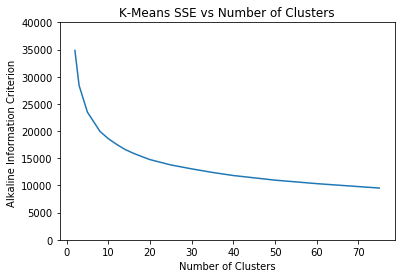

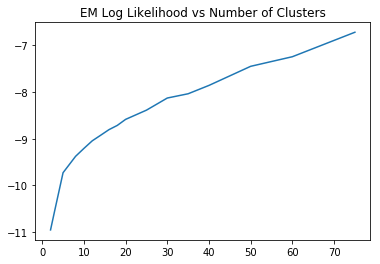

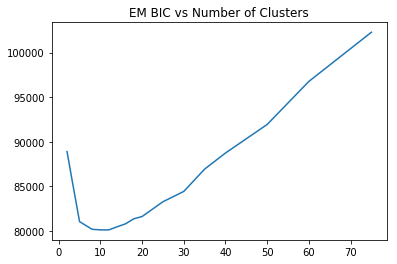

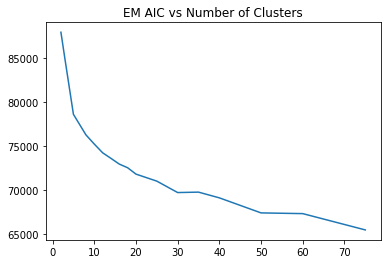

In [11]:
SSE = (-pd.DataFrame(SSE)).T
ax = SSE.plot(ylim=(0,40000), legend =False, title = 'K-Means SSE vs Number of Clusters')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("SSE")

ll = pd.DataFrame(ll).T
ll.plot(legend =False, title = 'EM Log Likelihood vs Number of Clusters')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Log Likelihood")

bic = pd.DataFrame(bic).T
bic.plot(legend =False, title = 'EM BIC vs Number of Clusters')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Bayesian Information Criterion ")

aic = pd.DataFrame(aic).T
aic.plot(legend =False, title = 'EM AIC vs Number of Clusters')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Alkaline Information Criterion ")

Text(0.5,1,'Log Likelihood and BIC vs Number of Clusters K')

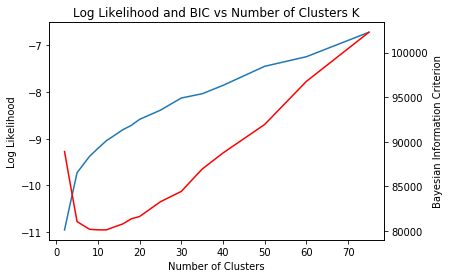

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(ll)
ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("Log Likelihood")

ax2 = ax1.twinx()
ax2.plot(bic, 'r-')
ax2.set_ylabel("Bayesian Information Criterion")

plt.title('Log Likelihood and BIC vs Number of Clusters K')

For n_clusters = 2 The average silhouette_score is : 0.2758808868060788
For n_clusters = 3 The average silhouette_score is : 0.23362794681549548
For n_clusters = 4 The average silhouette_score is : 0.24689719282992956
For n_clusters = 5 The average silhouette_score is : 0.2528102335390122
For n_clusters = 6 The average silhouette_score is : 0.18614256809185406
For n_clusters = 7 The average silhouette_score is : 0.18184289721260438
For n_clusters = 8 The average silhouette_score is : 0.16117005615213226
For n_clusters = 9 The average silhouette_score is : 0.14942918362054866
For n_clusters = 10 The average silhouette_score is : 0.15100849328114707
For n_clusters = 12 The average silhouette_score is : 0.14224957041206227
For n_clusters = 15 The average silhouette_score is : 0.14086224974546468
For n_clusters = 20 The average silhouette_score is : 0.13642314255080298
For n_clusters = 25 The average silhouette_score is : 0.12546450873772125
For n_clusters = 30 The average silhouette_score

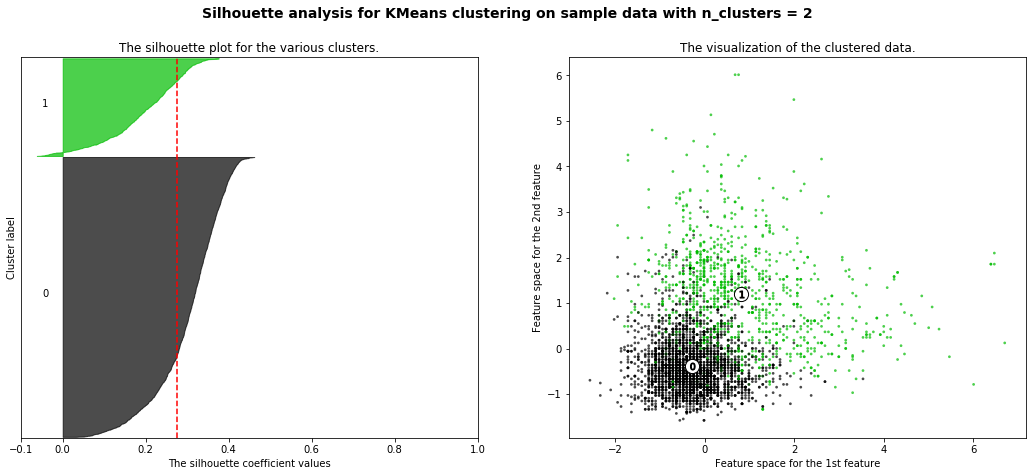

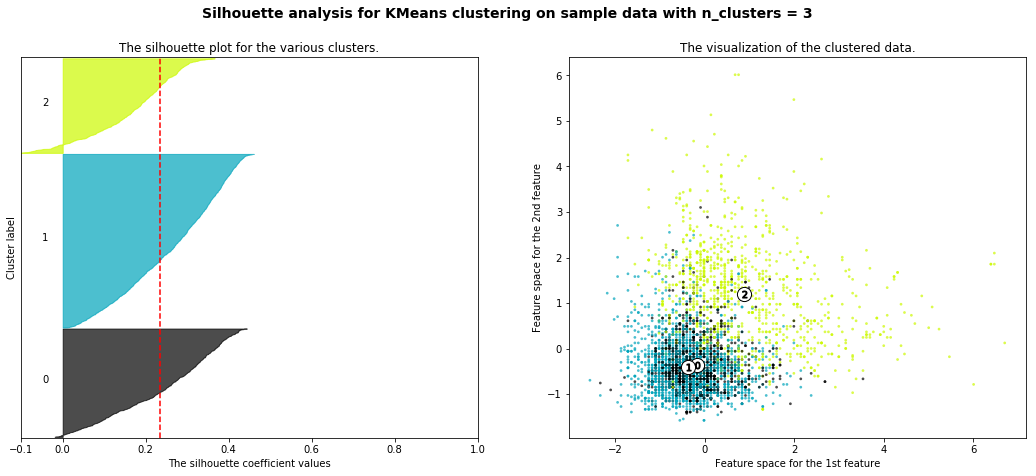

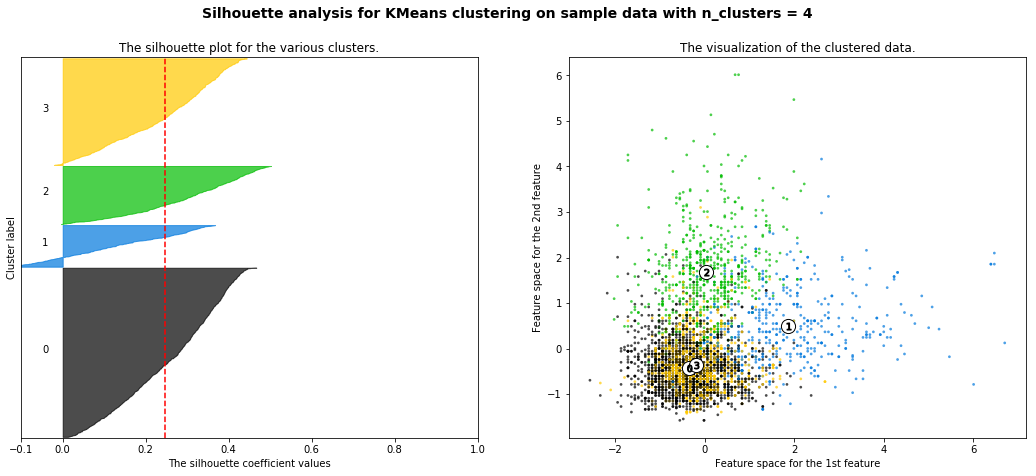

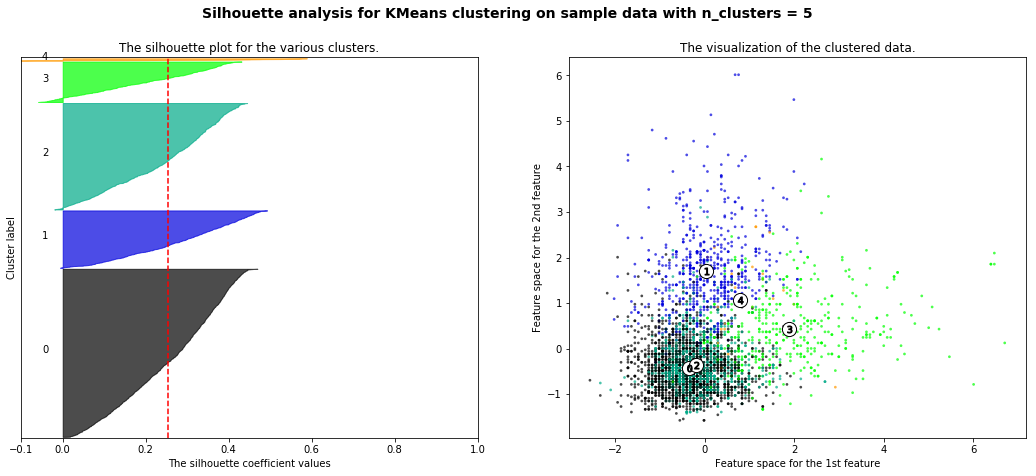

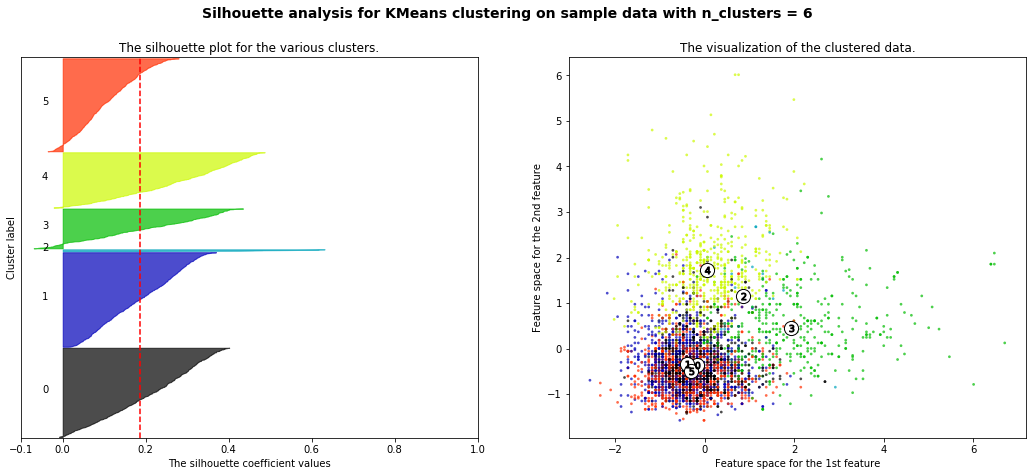

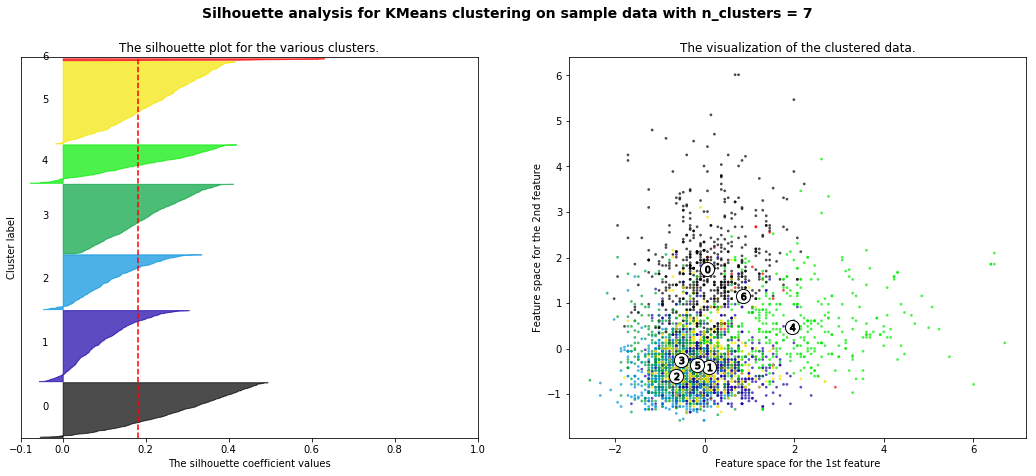

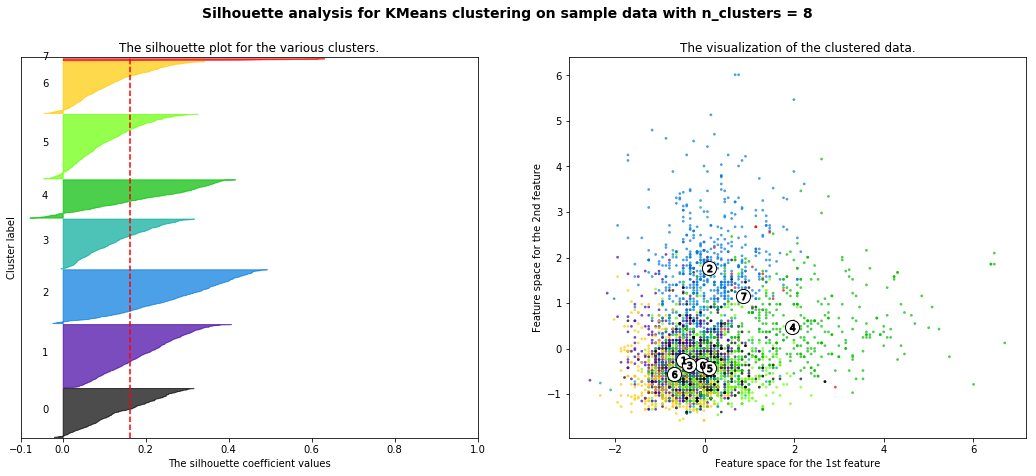

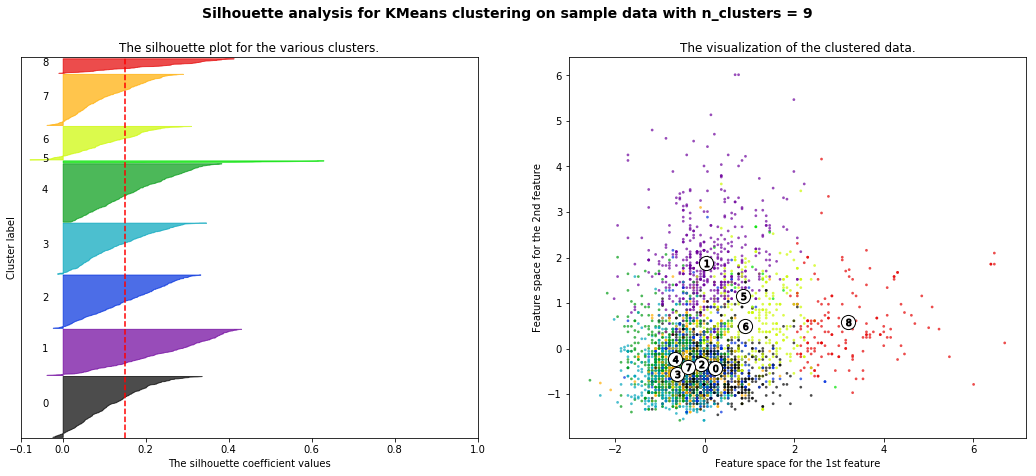

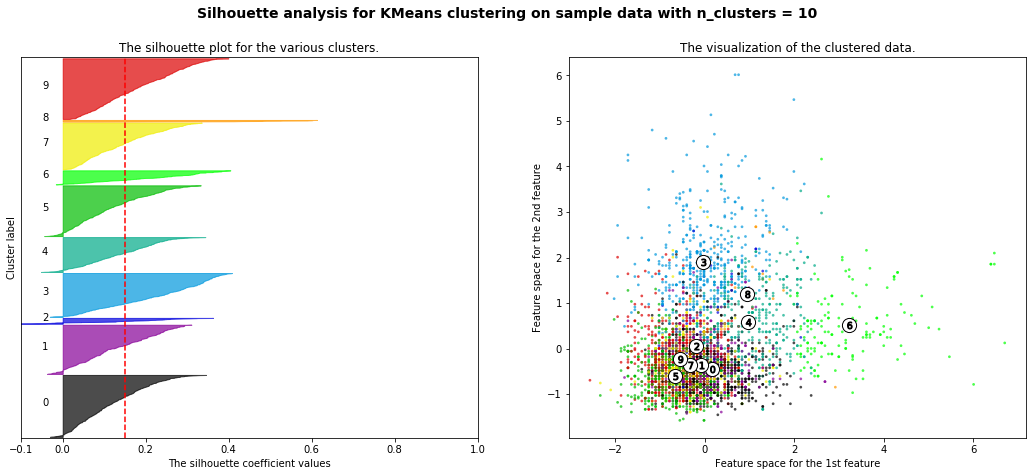

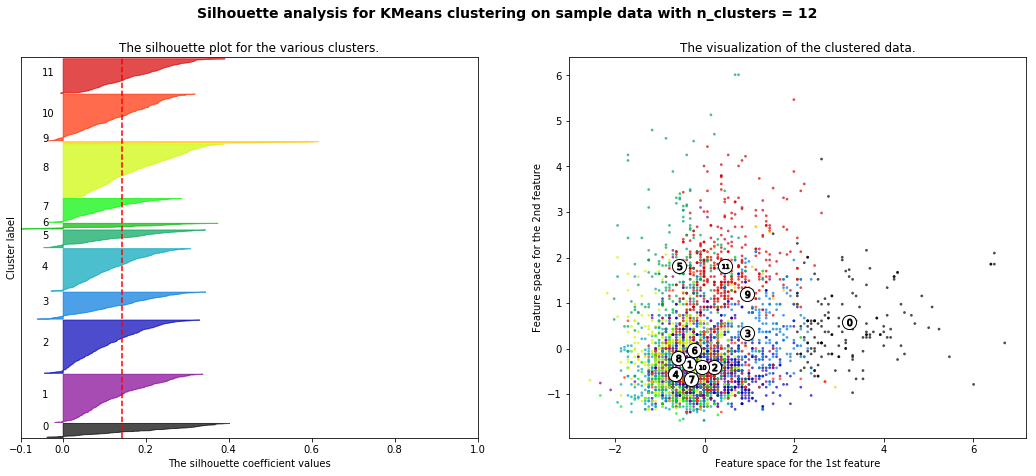

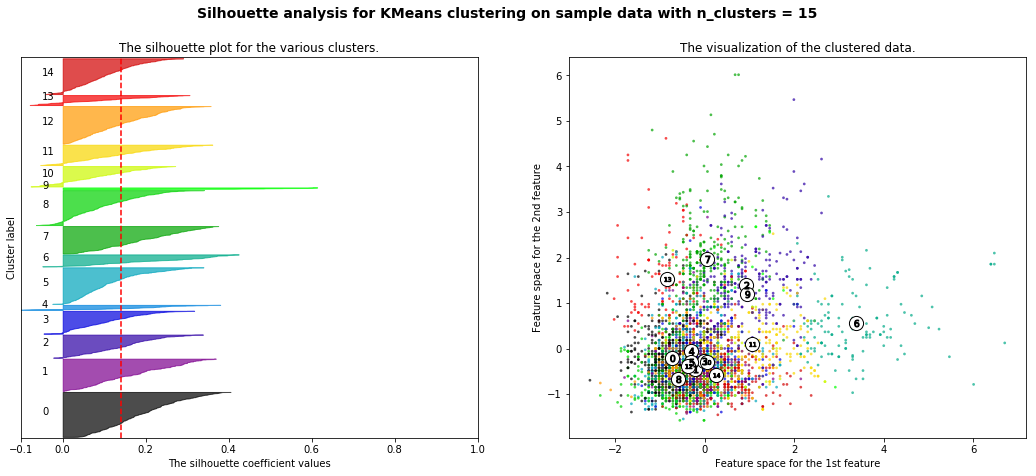

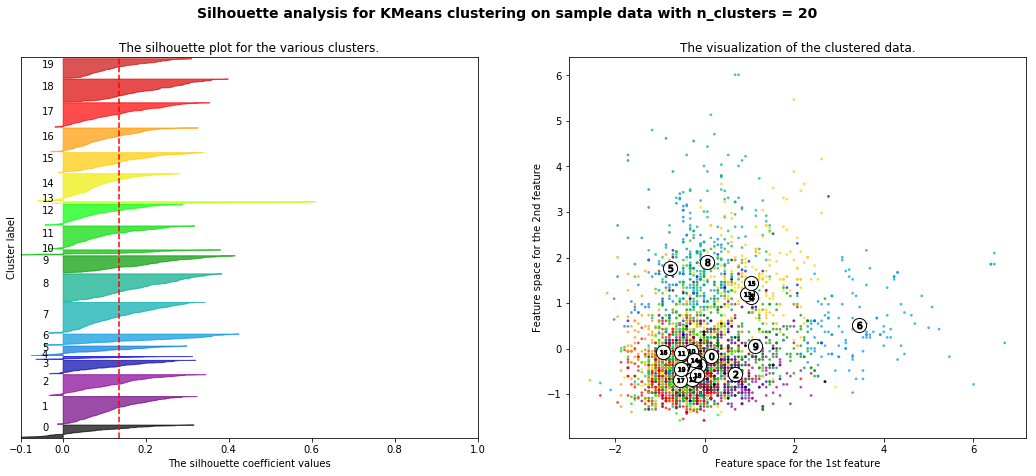

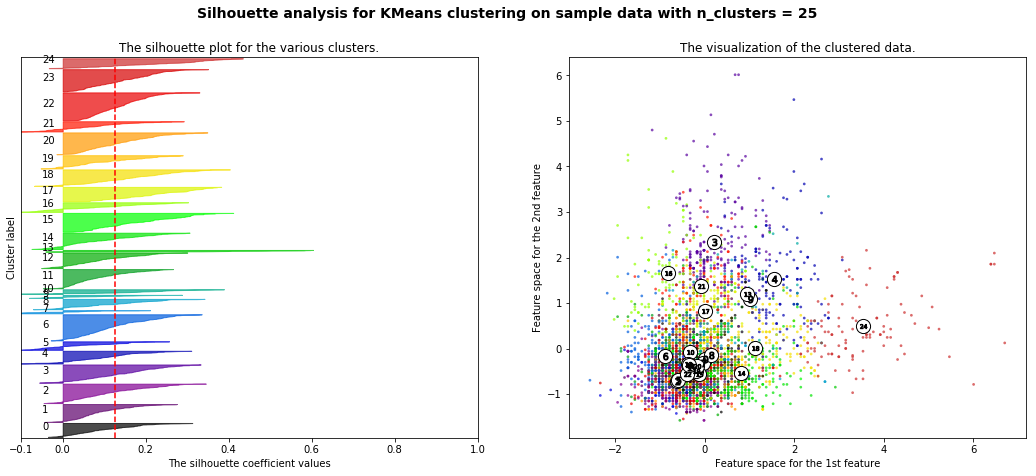

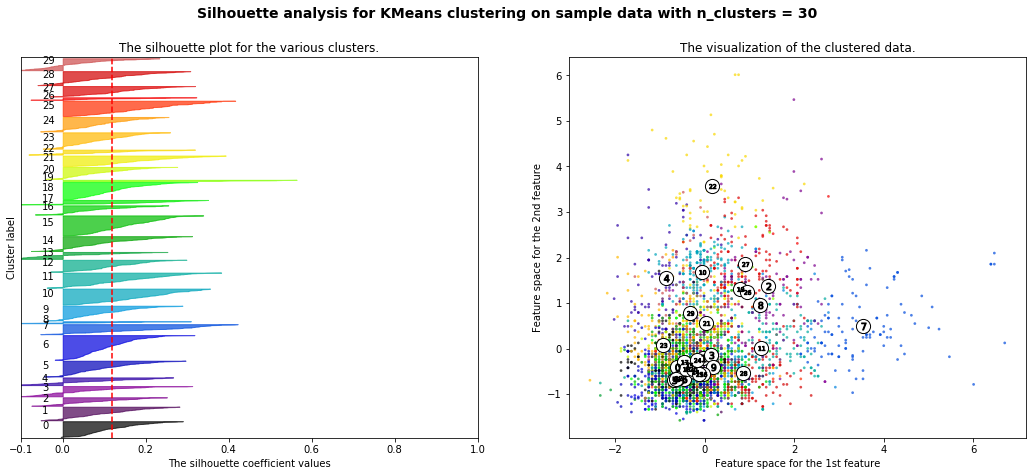

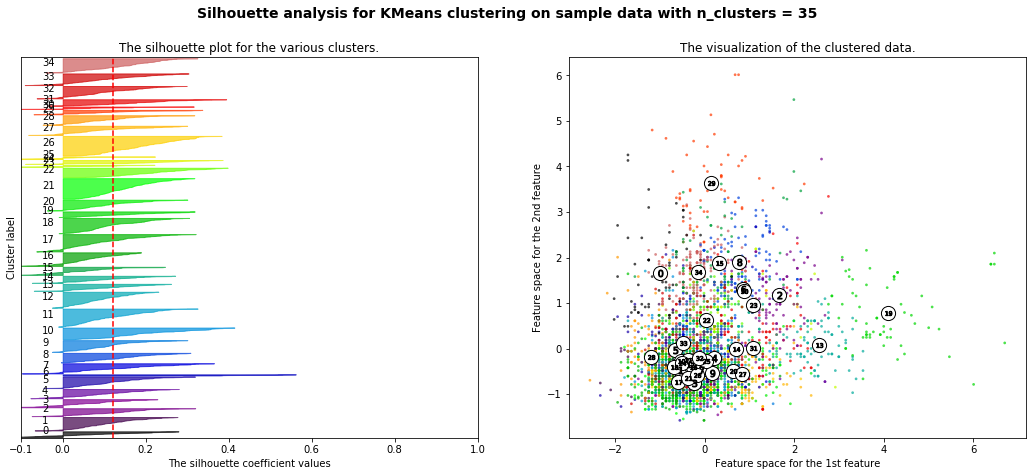

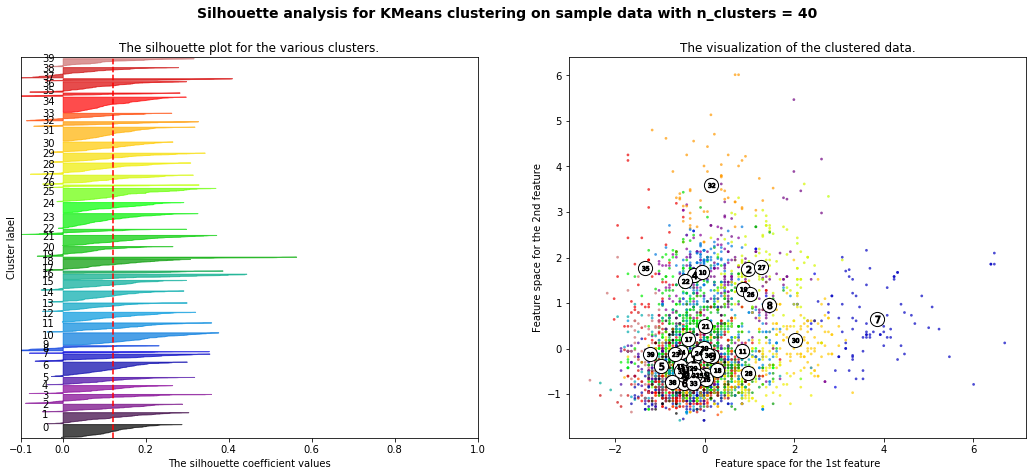

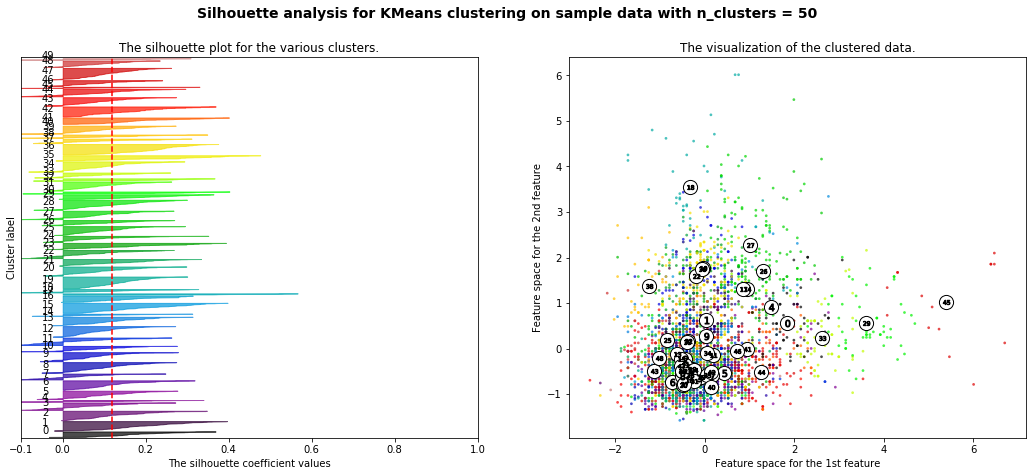

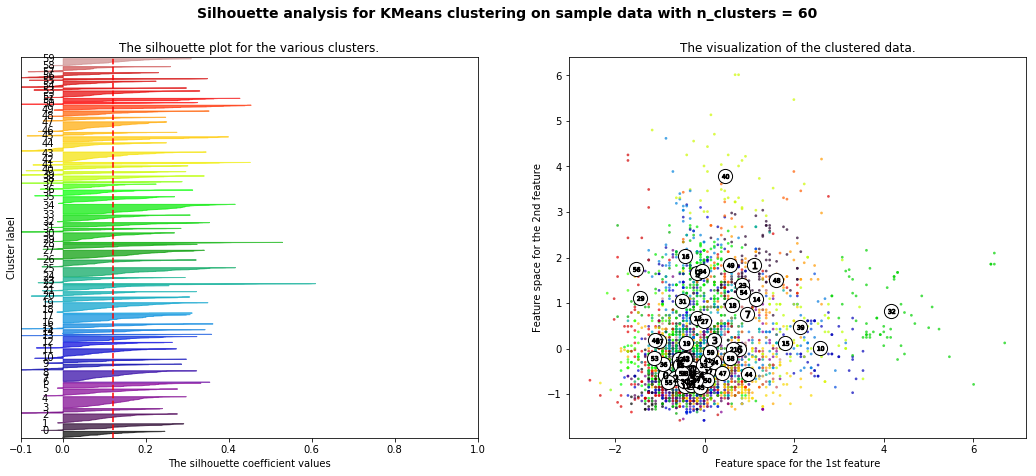

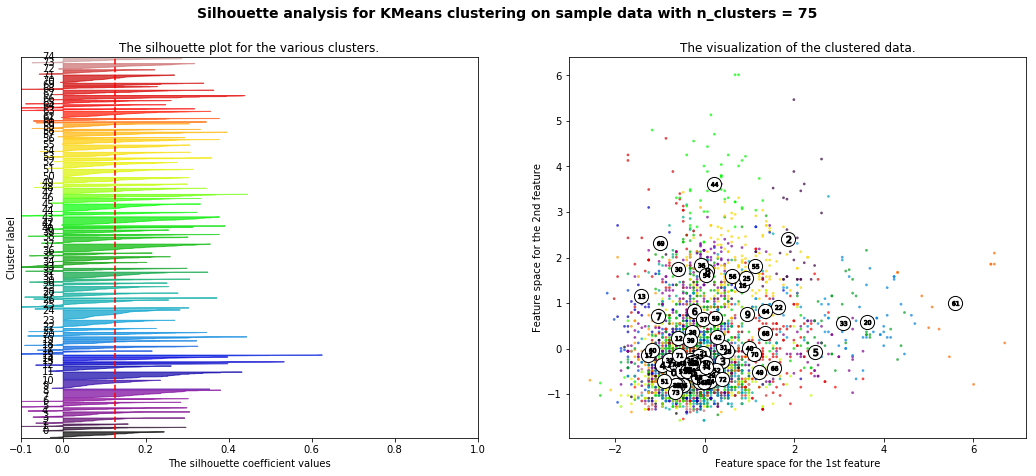

In [13]:
cluster_label_performance = []
range_n_clusters = [2,3,4,5,6,7,8,9,10,12,15,20,25,30,35,40,50,60,75]

for n_clusters in range_n_clusters:

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(x_train) + (n_clusters + 1) * 10])

    clusterer = kmeans(n_clusters=n_clusters, random_state=RANDOM_SEED)
    cluster_labels = clusterer.fit_predict(x_train)

    silhouette_avg = silhouette_score(x_train, cluster_labels)
    mutual_info_score = adjusted_mutual_info_score(y_train,  cluster_labels)
    
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    cluster_label_performance.append([n_clusters,silhouette_avg,mutual_info_score])

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_train, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(x_train[:, 0], x_train[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

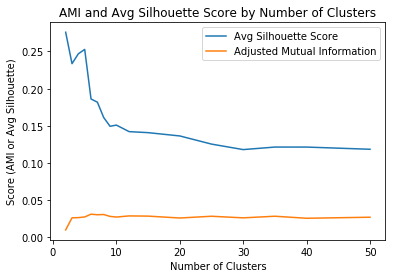

In [14]:
silhouette_data = pd.DataFrame(cluster_label_performance, columns = ['Number of Clusters','Avg Silhouette Score','Adjusted Mutual Information'])
silhouette_data = silhouette_data.set_index('Number of Clusters')
silhouette_data[0:17].plot()
plt.legend(loc='best')
plt.ylabel('Score (AMI or Avg Silhouette)')
plt.xlabel('Number of Clusters')
plt.title('AMI and Avg Silhouette Score by Number of Clusters')
plt.show()

In [330]:
del wine_train['kmean cluster']
del wine_train['em cluster']

In [331]:
best_km = kmeans(n_clusters = 4, init = 'random', random_state = RANDOM_SEED)
best_km.fit(x_train)

best_em = GMM(n_components = 8,  random_state = RANDOM_SEED)
best_em.fit(x_train)

##convert to percentages
em_labels = best_em.predict(x_train)
km_labels = best_km.predict(x_train)

em_means = pd.DataFrame(best_em.means_, columns = list(wine_train.iloc[:,:-1]))
km_means = pd.DataFrame(best_km.cluster_centers_, columns = list(wine_train.iloc[:,:-1]))

wine_train['kmean cluster'] = km_labels
wine_train['em cluster'] = em_labels

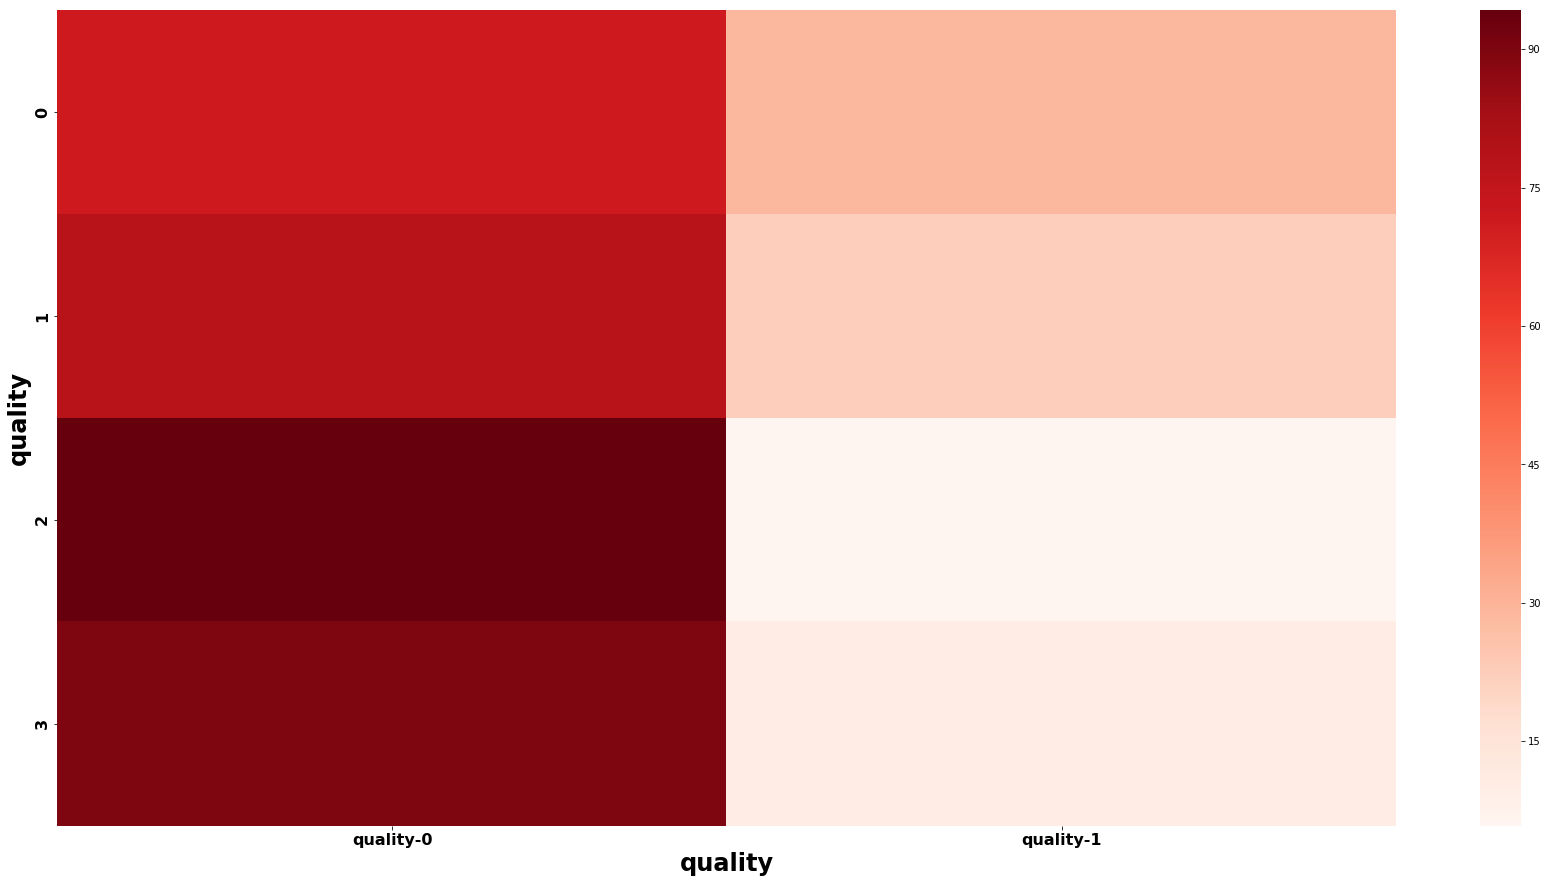

In [332]:
clusters = wine_train.groupby(['kmean cluster', 'quality']).agg({'quality': 'size'})
cluster_pcts = clusters.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))

fig2, ax2 = plt.subplots(figsize = (30, 15))
sns.heatmap(cluster_pcts.unstack(level = 'quality'), ax = ax2, cmap = 'Reds')

ax2.set_xlabel('quality', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('quality', fontdict = {'weight': 'bold', 'size': 24})

for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")

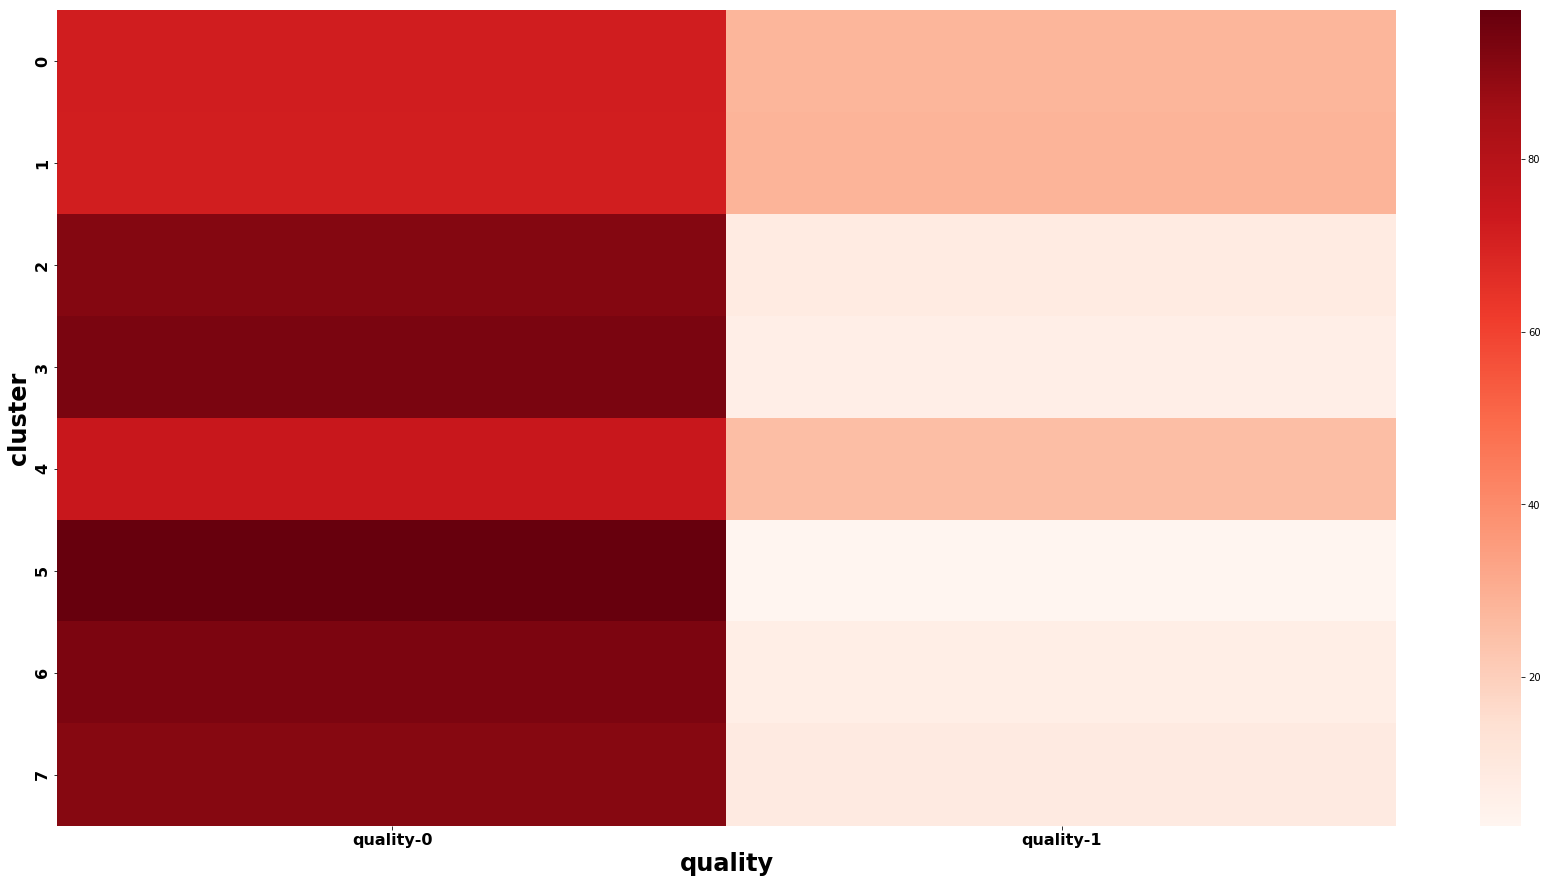

In [333]:
clusters = wine_train.groupby(['em cluster', 'quality']).agg({'quality': 'size'})
cluster_pcts = clusters.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))

fig2, ax2 = plt.subplots(figsize = (30, 15))
sns.heatmap(cluster_pcts.unstack(level = 'quality'), ax = ax2, cmap = 'Reds')

ax2.set_xlabel('quality', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")

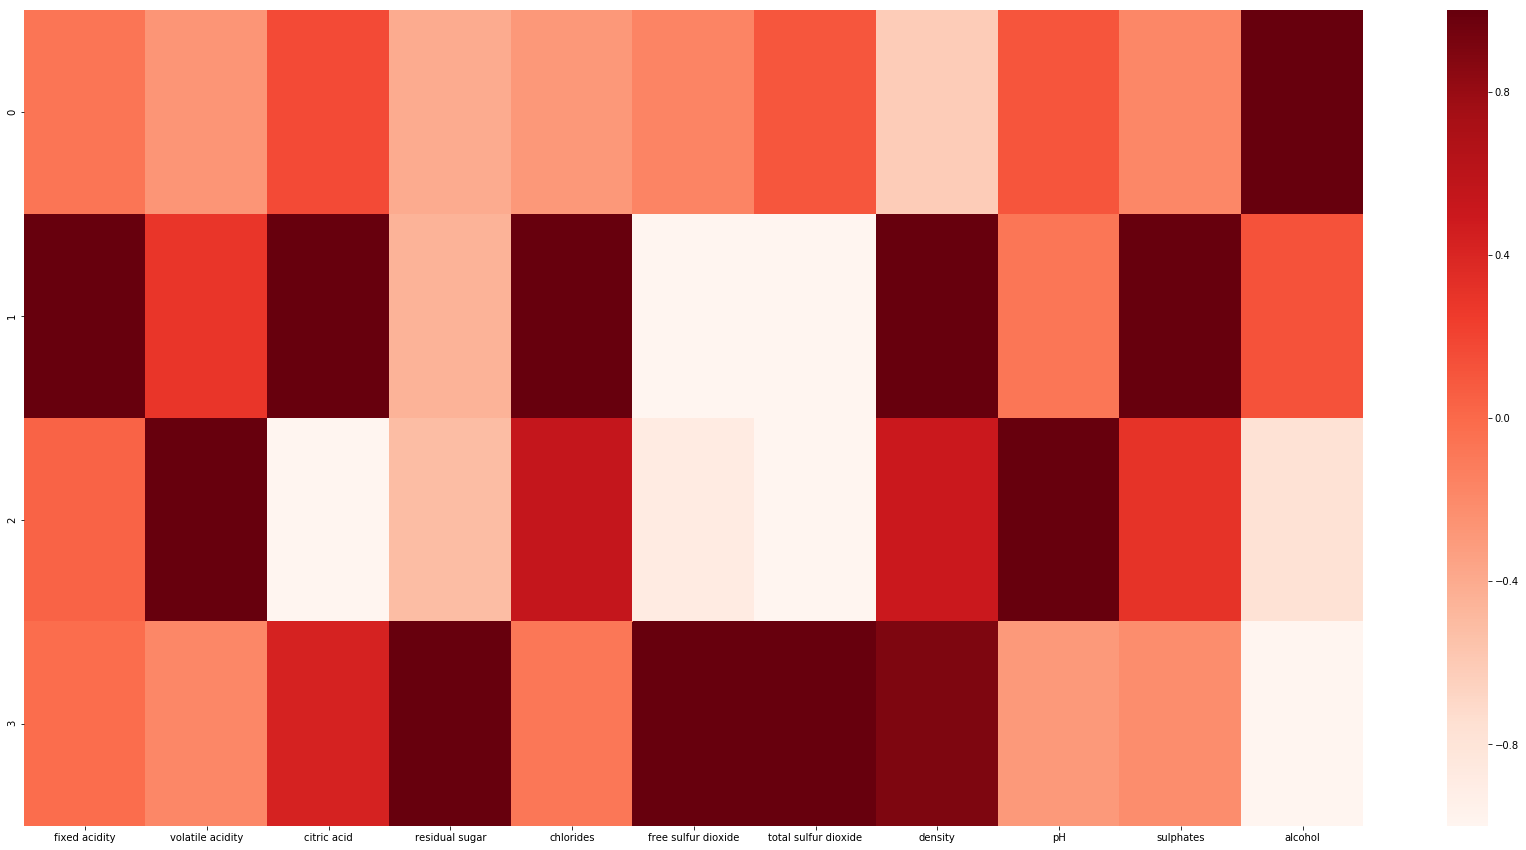

In [334]:
km_means = km_means.div(km_means.max(axis=0), axis=1)
fig2, ax2 = plt.subplots(figsize = (30, 15))
sns.heatmap(km_means, ax = ax2, cmap = 'Reds', vmin=-1, vmax=1)

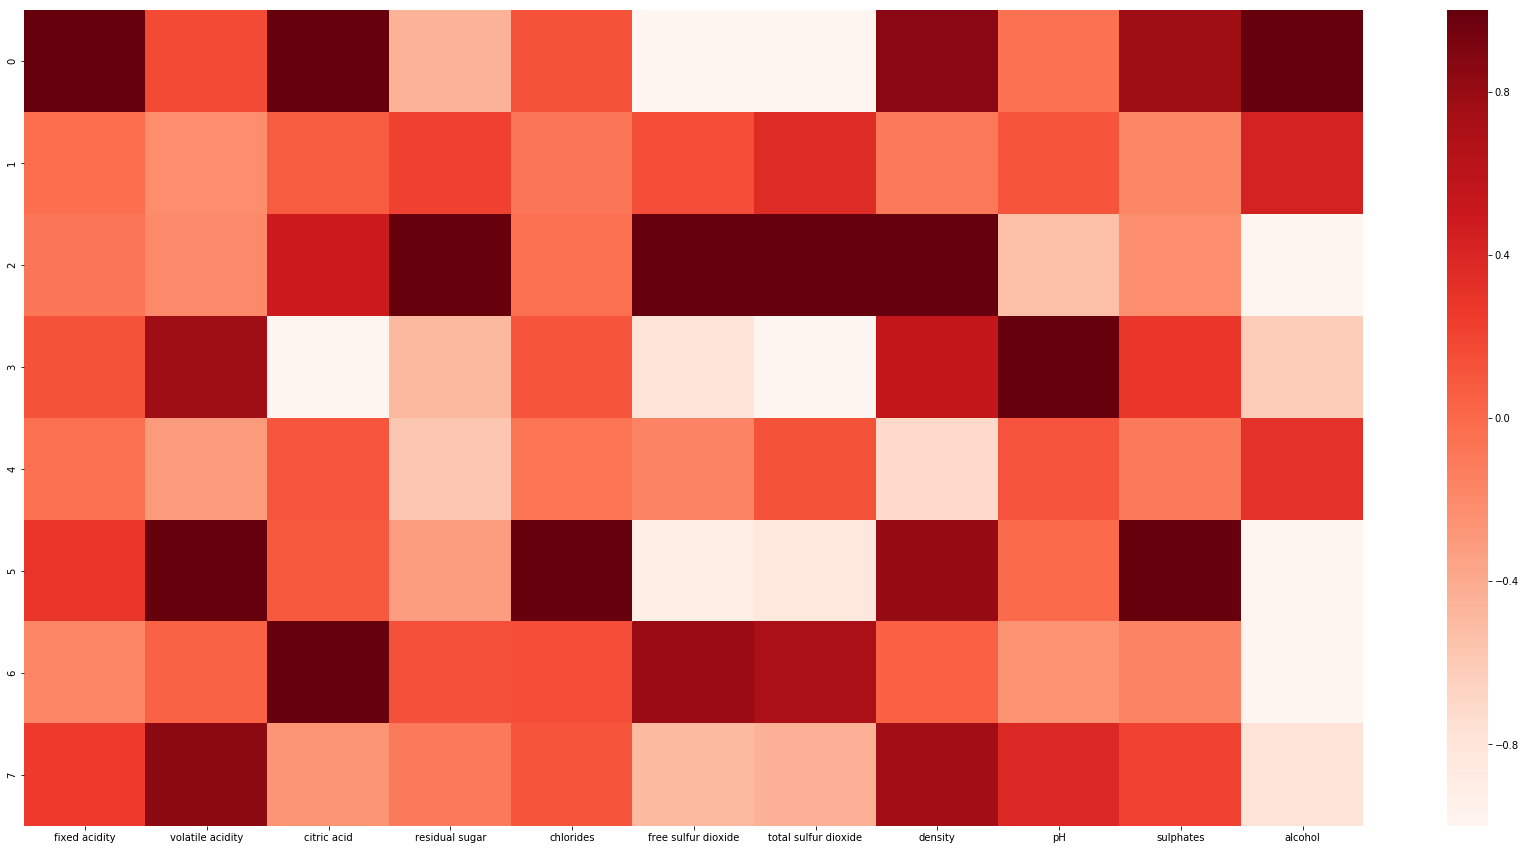

In [335]:
em_means = em_means.div(em_means.max(axis=0), axis=1)
fig2, ax2 = plt.subplots(figsize = (30, 15))
sns.heatmap(em_means, ax = ax2, cmap = 'Reds', vmin=-1, vmax=1)

In [266]:
from sklearn.metrics.pairwise import cosine_similarity

n_components = [2,3,4,5,6,7,8,9,10,11]
pca_variances = []
print('\nRunning PCA ...')
j = 0
for n in n_components:
    pca = PCA(n_components=n, svd_solver='full', random_state=RANDOM_SEED)
    X_pca = pca.fit_transform(x_train)
    explained_variance = pca.explained_variance_ratio_.sum()
    pca_explained = pca.explained_variance_ratio_[j]
    rce = reconstructionError(pca, x_train)
    #rce = 1 - cosine_similarity(pca.inverse_transform(X_pca),x_train)[0][0]
    print(str(n)+ ' Explained variance: %.4f' % explained_variance)
    print(str(n)+ ' Reconstruction Error: %.4f' % rce)
    pca_variances.append((n,explained_variance,pca_explained, rce))
    j+=1

pca_data = pd.DataFrame(pca_variances, columns=['Number of Components','Cumulative Explained Variance', 'Component Explained Variance','Reconstruction Error'])


Running PCA ...
2 Explained variance: 0.5153
2 Reconstruction Error: 0.5356
3 Explained variance: 0.6607
3 Reconstruction Error: 0.3750
4 Explained variance: 0.7509
4 Reconstruction Error: 0.2768
5 Explained variance: 0.8188
5 Reconstruction Error: 0.2015
6 Explained variance: 0.8694
6 Reconstruction Error: 0.1452
7 Explained variance: 0.9146
7 Reconstruction Error: 0.0960
8 Explained variance: 0.9497
8 Reconstruction Error: 0.0551
9 Explained variance: 0.9799
9 Reconstruction Error: 0.0223
10 Explained variance: 0.9971
10 Reconstruction Error: 0.0032
11 Explained variance: 1.0000
11 Reconstruction Error: 0.0000


Text(0.5,17.2,'Number of Principal Components')

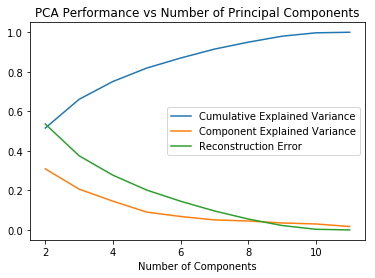

In [267]:
pca_data.plot(title = 'PCA Performance vs Number of Principal Components'
              ,x="Number of Components"
              , y=["Cumulative Explained Variance","Component Explained Variance", "Reconstruction Error"])
ax.set_xlabel("Number of Principal Components")

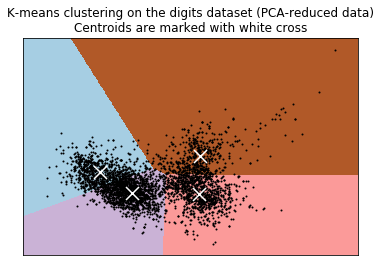

In [237]:
# #############################################################################
# Visualize the results on PCA-reduced data
reduced_data = PCA(n_components=2).fit_transform(x_train)
best_kmeans = kmeans(init='k-means++', n_clusters=4, n_init=10)
best_kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = best_kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = best_kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

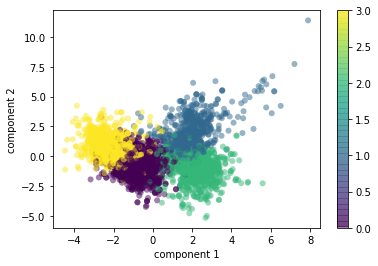

In [238]:
pca = PCA(n_components=2, random_state=RANDOM_SEED)
projected = pca.fit_transform(x_train)

plt.scatter(projected[:, 0], projected[:, 1],
            c=wine_train['kmean cluster'], edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [448]:
pca = PCA(n_components=2, random_state=RANDOM_SEED)
projected = pca.fit_transform(x_train)
plt.scatter(projected[:, 0], projected[:, 1],
            c=wine_train['em cluster'], edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();


array([[ 2.77517393, -1.60009085],
       [ 2.77584298, -0.52906177],
       [ 2.72562519, -0.59756105],
       ...,
       [-0.35370949, -0.72972745],
       [ 0.26835163, -2.31511591],
       [-0.03283438,  1.32178516]])

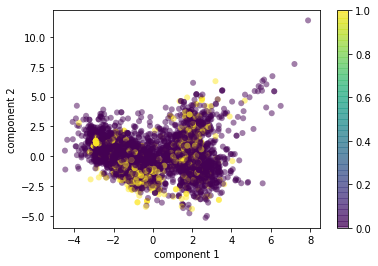

In [240]:
pca = PCA(n_components=2, random_state=RANDOM_SEED)
projected = pca.fit_transform(x_train)

plt.scatter(projected[:, 0], projected[:, 1],
            c=wine_train['quality'], edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

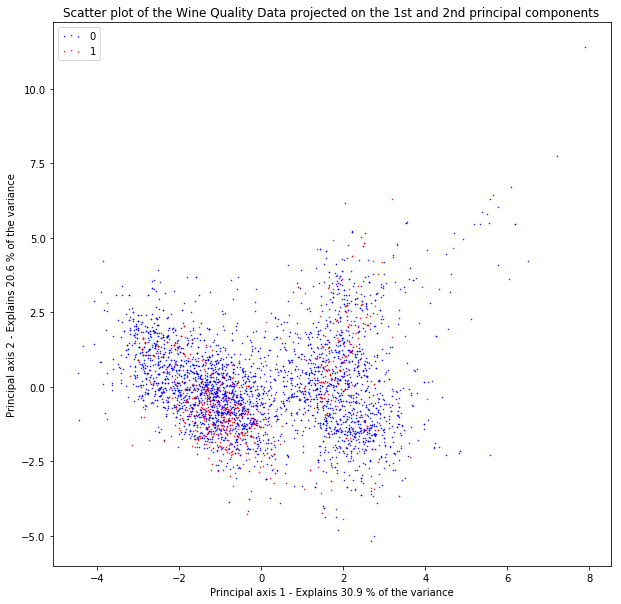

In [241]:
##visualizing PCA with true labels
colors = ['blue', 'red']
target_names = np.unique(wine_train['quality'])
X_pca = projected

plt.figure(1, figsize=(10, 10))

for color, i, target_name in zip(colors, [0,1], target_names):
    plt.scatter(X_pca[y_train == i, 0], X_pca[y_train == i, 1], color=color, s=1,
                alpha=1, label=target_name, marker='.')
plt.legend(loc='best', shadow=False, scatterpoints=3)
plt.title(
        "Scatter plot of the Wine Quality Data projected on the 1st "
        "and 2nd principal components")
plt.xlabel("Principal axis 1 - Explains %.1f %% of the variance" % (
        pca.explained_variance_ratio_[0] * 100.0))
plt.ylabel("Principal axis 2 - Explains %.1f %% of the variance" % (
        pca.explained_variance_ratio_[1] * 100.0))

plt.savefig('pca-wine_quality-01.png', dpi=150)
plt.show()

In [207]:
pca_best = PCA(n_components=5, random_state=RANDOM_SEED)
pca_projection = pca_best.fit_transform(x_train)
reconstructionError(pca_best, x_train)

0.20148356369160092

In [197]:
pca

PCA(copy=True, iterated_power='auto', n_components=2, random_state=5,
  svd_solver='auto', tol=0.0, whiten=False)

In [198]:
pca_best

PCA(copy=True, iterated_power='auto', n_components=2, random_state=1,
  svd_solver='auto', tol=0.0, whiten=False)

In [180]:
print('TSNE')
tsne = TSNE(n_components=2, init='random', random_state=0, verbose =10)
proj = tsne.fit_transform(x_train)

print('Clustering')
# Compute the clusters
best_kmeans = kmeans(n_clusters=4, random_state=RANDOM_SEED)
clusters = best_kmeans.fit_predict(x_train)
clusters = clusters + 1

from scipy.stats import mode

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(1,9):
    mask = (clusters == i)
    labels[mask] = mode(wine_train['quality'][mask])[0]

# Compute the accuracy
print(accuracy_score(wine_train['quality'], labels))
print(labels)

#print('TSNE')
#tsne = TSNE(n_components=2, init='pca', random_state=1001, perplexity=30, method='barnes_hut', n_iter=1000, verbose=1)
#X_tsne = tsne.fit_transform(x_train) # this will either fail or take a while (most likely overnight)

TSNE
Clustering
0.822
[0 0 0 ... 0 0 0]


Plotting


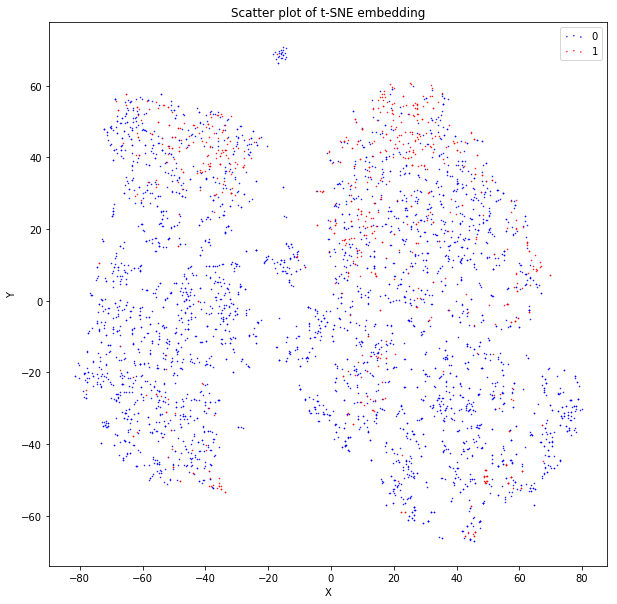

In [182]:
X_tsne = proj

print('Plotting')
#y_train = wine_['variety_mapping']

plt.figure(2, figsize=(10, 10))
target_names = np.unique(wine_train['quality'])
colors = ['blue', 'red']

for color, i, target_name in zip(colors, [0,1], target_names):
    plt.scatter(X_tsne[y_train == i, 0], X_tsne[y_train == i, 1], color=color, s=1,
                 alpha=1, label=target_name, marker='.')
plt.legend(loc='best', shadow=False, scatterpoints=3)
plt.title('Scatter plot of t-SNE embedding')
plt.xlabel('X')
plt.ylabel('Y')

plt.savefig('t-SNE-wine_quality.png', dpi=150)
plt.show()

In [183]:
# %% For chart 4/5
tnse_wine_reviews = TSNE(verbose=10,random_state=RANDOM_SEED).fit_transform(x_train)
tnse_wine_reviews = pd.DataFrame(np.hstack((tnse_wine_reviews,np.atleast_2d(y_train).T)),columns=['x','y','target'])
tnse_wine_reviews.to_csv('wine_quality_tnse_2d.csv')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.003s...
[t-SNE] Computed neighbors for 4000 samples in 0.340s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.773824
[t-SNE] Computed conditional probabilities in 0.096s
[t-SNE] Iteration 50: error = 83.8018265, gradient norm = 0.0542140 (50 iterations in 6.177s)
[t-SNE] Iteration 100: error = 77.1651154, gradient norm = 0.0047693 (50 iterations in 5.659s)
[t-SNE] Iteration 150: error = 76.5054321, gradient norm = 0.0014517 (50 iterations in 5.098s)
[t-SNE] Iteration 200: error = 76.3671494, gradient norm = 0.0006586 (50 iterations in 4.990s)
[t-SNE] Iteration 250: error = 76.3207016, gradient norm = 0.0004188 (50 iterations in 5.082s)
[t-SNE] KL divergence after 250 iterati

In [362]:
##ICA
dims = [2,3,4,5,6,7,8,9,10,11]
#raise
#%% data for 1

ica = FastICA(random_state=RANDOM_SEED)
kurt = {}
rce = {}
for dim in dims:
    ica.set_params(n_components=dim)
    tmp = ica.fit_transform(x_train)
    tmp = pd.DataFrame(tmp)
    tmp = tmp.kurt(axis=0)
    kurt[dim] = tmp.abs().mean()
    rce[dim] = reconstructionError(ica, x_train)
    #print(str(dim) + ',' + str(kurt[dim]))
    
kurt = pd.Series(kurt, name = 'Mean Kurtosis') 
rce = pd.Series(rce, name = 'Reconstruction Error')
kurt.to_csv('ica wine quality kurtosis components.csv')
kurt = pd.DataFrame(kurt)
rce = pd.DataFrame(rce)

0   -0.964113 
1    1.762849 
2    0.572933 
3   -0.617317 
4    54.836754
dtype: float64


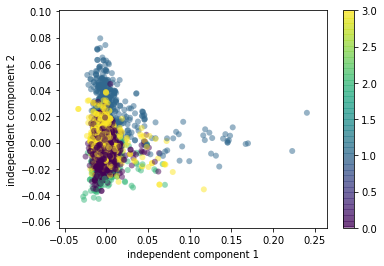

In [452]:
ica = FastICA(random_state=RANDOM_SEED, n_components = 5)
ica_projections = pd.DataFrame(ica.fit_transform(x_train))
tmp = pd.DataFrame(ica_projections)
tmp = tmp.kurt(axis=0)
print(tmp)

plt.scatter(ica_projections.iloc[:, 4], ica_projections.iloc[:, 1],
            c=wine_train['kmean cluster'], edgecolor='none', alpha=0.5)
plt.xlabel('independent component 1')
plt.ylabel('independent component 2')
plt.colorbar();

In [ ]:
ica = FastICA(random_state=RANDOM_SEED, n_components = 5)
ica_projections = pd.DataFrame(ica.fit_transform(x_train))
tmp = pd.DataFrame(ica_projections)
tmp = tmp.kurt(axis=0)
print(tmp)

plt.scatter(ica_projections.iloc[:, 4], ica_projections.iloc[:, 1],
            c=wine_train['q'], edgecolor='none', alpha=0.5)
plt.xlabel('independent component 1')
plt.ylabel('independent component 2')
plt.colorbar();

0   -0.964113 
1    1.762849 
2    0.572933 
3   -0.617317 
4    54.836754
dtype: float64


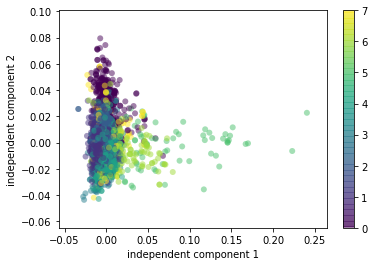

In [453]:
ica = FastICA(random_state=RANDOM_SEED, n_components = 5)
ica_projections = pd.DataFrame(ica.fit_transform(x_train))
tmp = pd.DataFrame(ica_projections)
tmp = tmp.kurt(axis=0)
print(tmp)

plt.scatter(ica_projections.iloc[:, 4], ica_projections.iloc[:, 1],
            c=wine_train['em cluster'], edgecolor='none', alpha=0.5)
plt.xlabel('independent component 1')
plt.ylabel('independent component 2')
plt.colorbar();

0   -0.964113 
1    1.762849 
2    0.572933 
3   -0.617317 
4    54.836754
dtype: float64


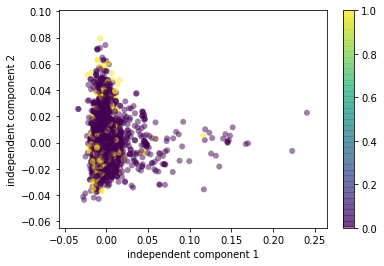

In [454]:
ica = FastICA(random_state=RANDOM_SEED, n_components = 5)
ica_projections = pd.DataFrame(ica.fit_transform(x_train))
tmp = pd.DataFrame(ica_projections)
tmp = tmp.kurt(axis=0)
print(tmp)

plt.scatter(ica_projections.iloc[:, 4], ica_projections.iloc[:, 1],
            c=wine_train['quality'], edgecolor='none', alpha=0.5)
plt.xlabel('independent component 1')
plt.ylabel('independent component 2')
plt.colorbar();

Text(0.5,1,'Mean Kurtosis (Blue) and Reconstruction Error (Red) vs N Independent Components')

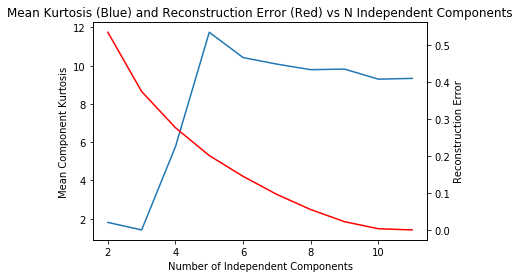

In [361]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(kurt)
ax1.set_xlabel("Number of Independent Components")
ax1.set_ylabel("Mean Component Kurtosis")

ax2 = ax1.twinx()
ax2.plot(rce, 'r-')
ax2.set_ylabel("Reconstruction Error")
rce = pd.DataFrame(rce)
plt.title('Mean Kurtosis (Blue) and Reconstruction Error (Red) vs N Independent Components')

In [363]:
##RANDOMIZED PROJECTIONS

from helpers import   pairwiseDistCorr,nn_reg,nn_arch,reconstructionError
from itertools import product

dims = [2,3,4,5,6,7,8,9,10,11]
tmp = defaultdict(dict)
for i,dim in product(range(10),dims):
    rp = SparseRandomProjection(random_state=i, n_components=dim)
    tmp[dim][i] = pairwiseDistCorr(rp.fit_transform(x_train), x_train)
    #print(str(dim) + ',' + str(tmp[dim][i]))

pairwise =pd.DataFrame(tmp).T
pairwise.to_csv('wine quality RP pairwise.csv')

tmp = defaultdict(dict)
for i,dim in product(range(10),dims):
    rp = SparseRandomProjection(random_state=i, n_components=dim)
    rp.fit(x_train)    
    tmp[dim][i] = reconstructionError(rp, x_train)
    #print(str(dim) + ',' + str(tmp[dim][i]))

rce_rp =pd.DataFrame(tmp).T
rce_rp.to_csv('wine quality RP reconstruction.csv')

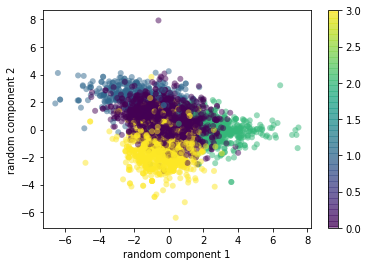

In [471]:
rp = SparseRandomProjection(random_state=RANDOM_SEED, n_components = 5)
rp_projections = pd.DataFrame(rp.fit_transform(x_train))

plt.scatter(rp_projections.iloc[:, 1], rp_projections.iloc[:, 2],
            c=wine_train['kmean cluster'], edgecolor='none', alpha=0.5)
plt.xlabel('random component 1')
plt.ylabel('random component 2')
plt.colorbar();

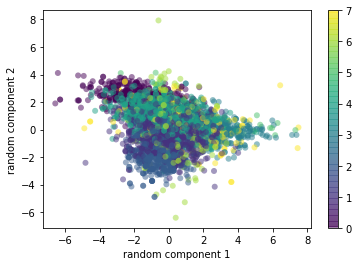

In [472]:
rp = SparseRandomProjection(random_state=RANDOM_SEED, n_components = 5)
rp_projections = pd.DataFrame(rp.fit_transform(x_train))

plt.scatter(rp_projections.iloc[:, 1], rp_projections.iloc[:, 2],
            c=wine_train['em cluster'], edgecolor='none', alpha=0.5)
plt.xlabel('random component 1')
plt.ylabel('random component 2')
plt.colorbar();

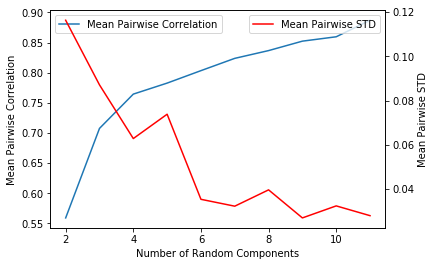

In [434]:
pairwise_joined = (pd.concat((pairwise.mean(axis=1), pairwise.std(axis=1)), axis =1))
pairwise_joined.columns = ["Mean Pairwise Correlation", "Mean Pairwise Standard Deviation"]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(pairwise_joined.iloc[:,0], label = 'Mean Pairwise Correlation')
ax1.set_xlabel("Number of Random Components")
ax1.set_ylabel("Mean Pairwise Correlation")
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(pairwise_joined.iloc[:,1], 'r-', label = 'Mean Pairwise STD')
ax2.set_ylabel("Mean Pairwise STD")
ax2.legend()

#rce = pd.DataFrame(pairwise_joined)
#plt.title('Mean Pa (Blue) and Reconstruction Error (Red) vs N Independent Components')

In [31]:
x_train.shape

(4000, 11)

In [53]:
#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components = 2)
lda_projection = lda.fit_transform(x_train, y_train)
lda_labels = y_train.reshape(4000,1)

plt.scatter(lda_projection, np.zeros_like(lda_projection), vmin=0,c=lda_labels)

plt.yticks([])
plt.xlabel('LD component')
plt.xlabel('LD Component')
plt.title('Linear Discriminant Projection with Class Label Color')
plt.colorbar();

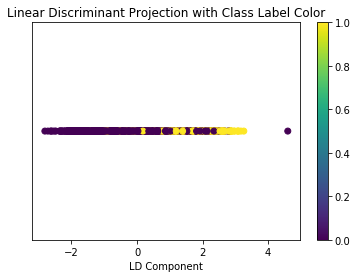

In [58]:
plt.scatter(lda_projection, np.zeros_like(lda_projection), vmin=0,c=lda_labels)

plt.yticks([])
plt.xlabel('LD component')
plt.xlabel('LD Component')
plt.title('Linear Discriminant Projection with Class Label Color')
plt.colorbar();

In [60]:
def run_clustering_experiment(x_train, clusters, RANDOM_SEED):
    SSE = defaultdict(dict)
    ll = defaultdict(dict)
    bic = defaultdict(dict)
    aic = defaultdict(dict)
    silhoutte = defaultdict(dict)

    km = kmeans(random_state=RANDOM_SEED, init ='k-means++')
    gmm = GMM(random_state=RANDOM_SEED)

    st = clock()
    for k in clusters:
        km.set_params(n_clusters=k)
        gmm.set_params(n_components=k)
        km.fit(x_train )
        gmm.fit(x_train)
        SSE[k]['Wine'] = km.score(x_train)
        ll[k]['Wine'] = gmm.score(x_train)
        bic[k]['Wine'] = gmm.bic(x_train)  
        aic[k]['Wine'] = gmm.aic(x_train)   

        print(k, clock()-st, SSE[k]['Wine'])
       
    return SSE, ll, bic, aic

Text(0,0.5,'Alkaline Information Criterion ')

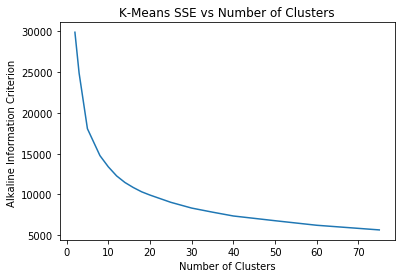

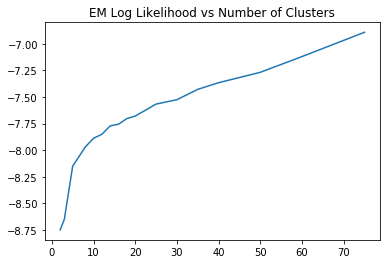

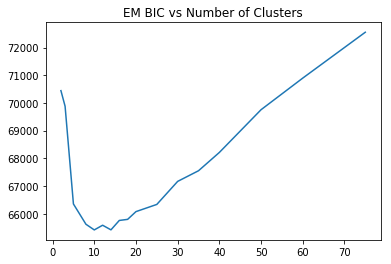

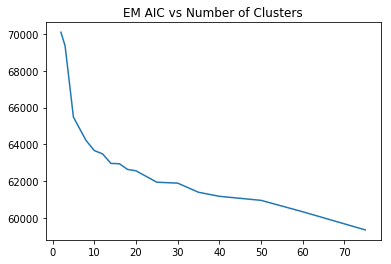

In [310]:
clusters =  [2,3,5,8,10,12,14,16,18,20,25,30,35,40,50,60,75]

##APPLY CLUSTERING EXPERIMENT ON THE REDUCED DATASET
pca = PCA(n_components=6, svd_solver='full', random_state=RANDOM_SEED)
x_pca = pca.fit_transform(x_train)
SSE_pca, ll_pca, bic_pca, aic_pca = run_clustering_experiment(x_pca, clusters, RANDOM_SEED)

SSE_pca = (-pd.DataFrame(SSE_pca)).T
ax = SSE_pca.plot(legend =False, title = 'K-Means SSE vs Number of Clusters')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("SSE")

ll_pca = pd.DataFrame(ll_pca).T
ll_pca.plot(legend =False, title = 'EM Log Likelihood vs Number of Clusters')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Log Likelihood")

bic_pca = pd.DataFrame(bic_pca).T
bic_pca.plot(legend =False, title = 'EM BIC vs Number of Clusters')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Bayesian Information Criterion ")

aic_pca = pd.DataFrame(aic_pca).T
aic_pca.plot(legend =False, title = 'EM AIC vs Number of Clusters')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Alkaline Information Criterion ")

2 0.08937199999991208 -36613.94963099844
3 0.21614399999998568 -26956.559370894538
5 0.4003460000000132 -19780.547261535314
8 0.7398230000000012 -14836.100223053765
10 1.2553589999999986 -13411.07453243689
12 1.882298999999989 -12343.331369411753
14 2.634068999999954 -11444.47698154368
16 3.490876999999955 -10741.291681481918
18 4.55020300000001 -10186.545212152403
20 5.51854400000002 -9579.3042048306
25 6.851279999999974 -8737.729948868982
30 8.353399999999965 -8053.138090662587
35 9.92991399999994 -7502.515124470173
40 11.964631999999938 -7010.36410393191
50 14.490730999999982 -6298.4266249820275
60 17.751919999999927 -5763.587214643713
75 21.13155699999993 -5070.76390238659


Text(17.2,0.5,'Alkaline Information Criterion ')

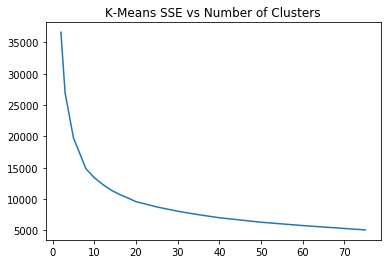

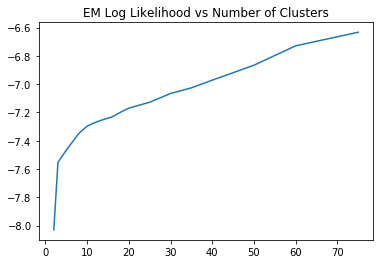

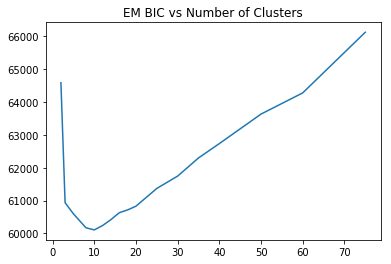

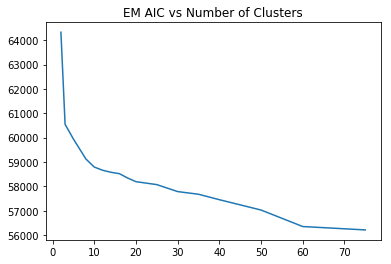

In [483]:
rp = SparseRandomProjection(random_state=RANDOM_SEED, n_components = 5)
x_rp = rp.fit_transform(x_train)
SSE_rp, ll_rp, bic_rp, aic_rp = run_clustering_experiment(x_rp, clusters, RANDOM_SEED)

SSE_rp = (-pd.DataFrame(SSE_rp)).T
SSE_rp.plot(legend =False, title = 'K-Means SSE vs Number of Clusters')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("SSE")

ll_rp = pd.DataFrame(ll_rp).T
ll_rp.plot(legend =False, title = 'EM Log Likelihood vs Number of Clusters')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Log Likelihood")

bic_rp = pd.DataFrame(bic_rp).T
bic_rp.plot(legend =False, title = 'EM BIC vs Number of Clusters')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Bayesian Information Criterion ")

aic_rp = pd.DataFrame(aic_rp).T
aic_rp.plot(legend =False, title = 'EM AIC vs Number of Clusters')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Alkaline Information Criterion ")

2 0.03700599999999099 -1471.360352008211
3 0.09009100000000103 -725.8002871203109
5 0.24335800000000063 -298.3752510390342
8 0.4547409999999985 -128.79170449099905
10 0.5841739999999902 -86.81000261266269
12 0.7521559999999994 -62.56147252812356
14 0.9198099999999982 -47.286836923391874
16 1.1025339999999915 -36.88085029368088
18 1.2846019999999925 -29.16171755751887
20 1.4921899999999937 -23.82154184754721
25 1.7046599999999899 -14.97322212096992
30 1.9669260000000008 -10.134323737100559
35 2.259379999999993 -7.36689906289916
40 2.579821999999993 -5.532483275145259
50 2.9776159999999976 -3.4422254928151963
60 3.462997999999999 -2.3981282462303573
75 4.0470320000000015 -1.4787055539278535


Text(17.2,0.5,'Alkaline Information Criterion ')

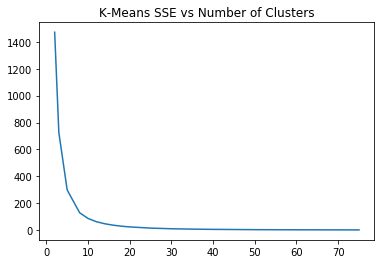

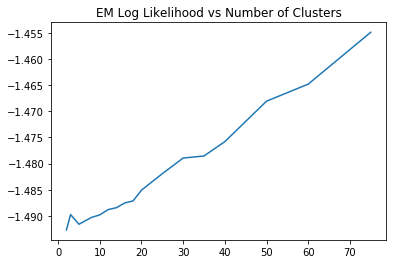

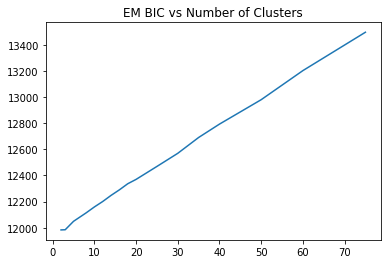

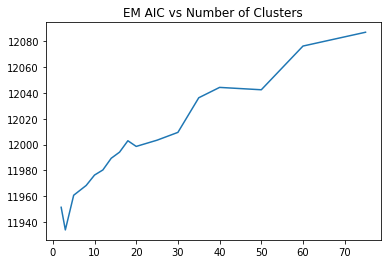

In [62]:
#rp = SparseRandomProjection(random_state=RANDOM_SEED, n_components = 5)
#x_rp = rp.fit_transform(x_train)
SSE_rp, ll_rp, bic_rp, aic_rp = run_clustering_experiment(lda_projection, clusters, RANDOM_SEED)

SSE_rp = (-pd.DataFrame(SSE_rp)).T
SSE_rp.plot(legend =False, title = 'K-Means SSE vs Number of Clusters')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("SSE")

ll_rp = pd.DataFrame(ll_rp).T
ll_rp.plot(legend =False, title = 'EM Log Likelihood vs Number of Clusters')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Log Likelihood")

bic_rp = pd.DataFrame(bic_rp).T
bic_rp.plot(legend =False, title = 'EM BIC vs Number of Clusters')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Bayesian Information Criterion ")

aic_rp = pd.DataFrame(aic_rp).T
aic_rp.plot(legend =False, title = 'EM AIC vs Number of Clusters')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Alkaline Information Criterion ")

In [ ]:
ica = FastICA(random_state=RANDOM_SEED, n_components = 5)
x_ica = ica.fit_transform(x_train)
SSE_ica, ll_ica, bic_ica, aic_ica = run_clustering_experiment(x_ica, clusters, RANDOM_SEED)

SSE_ica = (-pd.DataFrame(SSE_ica)).T
ax = SSE_ica.plot(legend =False, title = 'K-Means SSE vs Number of Clusters')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("SSE")

ll_ica = pd.DataFrame(ll_ica).T
ll_ica.plot(legend =False, title = 'EM Log Likelihood vs Number of Clusters')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Log Likelihood")

bic_ica = pd.DataFrame(bic_ica).T
bic_ica.plot(legend =False, title = 'EM BIC vs Number of Clusters')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Bayesian Information Criterion ")

aic_ica = pd.DataFrame(aic_ica).T
aic_ica.plot(legend =False, title = 'EM AIC vs Number of Clusters')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Alkaline Information Criterion ")

In [77]:
lda_projection

array([[ 0.83998933],
       [ 1.32347543],
       [ 0.21531694],
       ...,
       [ 0.02827612],
       [ 0.35881905],
       [-0.69788489]])

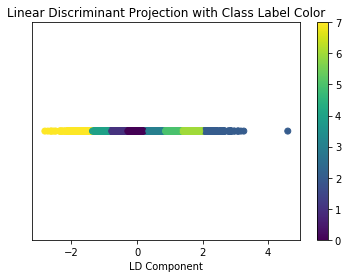

In [79]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components = 2)
lda_projection = lda.fit_transform(x_train, y_train)
lda_labels = y_train.reshape(4000,1)

dr_km = kmeans(n_clusters = 8, init = 'random', random_state = RANDOM_SEED)
dr_km.fit(lda_projection)

dr_em = GMM(n_components = 4,  random_state = RANDOM_SEED)
dr_em.fit(lda_projection)

dr_em_labels = dr_em.predict(lda_projection)
dr_km_labels = dr_km.predict(lda_projection).reshape(4000,1)

plt.scatter(lda_projection, np.zeros_like(lda_projection), vmin=0,c=dr_km_labels)

plt.yticks([])
plt.xlabel('LD component')
plt.xlabel('LD Component')
plt.title('Linear Discriminant Projection with Class Label Color')
plt.colorbar();

0    1.080143 
1    3.389683 
2   -0.575178 
3    54.207001
4    0.424985 
dtype: float64


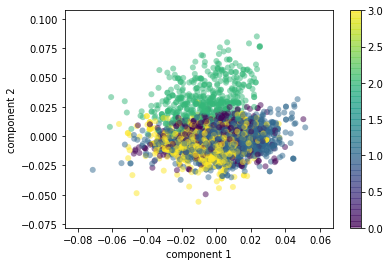

In [69]:
dr = FastICA(n_components=5, random_state=RANDOM_SEED)
projected = dr.fit_transform(x_train)
tmp = pd.DataFrame(projected)
tmp = tmp.kurt(axis=0)
print(tmp)

dr_km = kmeans(n_clusters = 4, init = 'random', random_state = RANDOM_SEED)
dr_km.fit(projected)

dr_em = GMM(n_components = 8,  random_state = RANDOM_SEED)
dr_em.fit(projected)

dr_em_labels = dr_em.predict(projected)
dr_km_labels = dr_km.predict(projected)

plt.scatter(projected[:, 4], projected[:, 1],
            c=dr_km_labels, edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

0    14.244273
1    0.784272 
2    0.155771 
3    3.707362 
4    1.693109 
dtype: float64


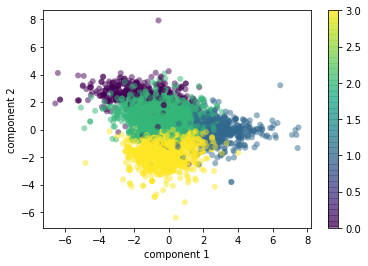

In [516]:
rp = SparseRandomProjection(random_state=RANDOM_SEED, n_components = 5)
projected = pd.DataFrame(rp.fit_transform(x_train))

tmp = pd.DataFrame(projected)
tmp = tmp.kurt(axis=0)
print(tmp)

dr_km = kmeans(n_clusters = 4, init = 'random', random_state = RANDOM_SEED)
dr_km.fit(projected)

dr_em = GMM(n_components = 8,  random_state = RANDOM_SEED)
dr_em.fit(projected)

dr_em_labels = dr_em.predict(projected)
dr_km_labels = dr_km.predict(projected)

plt.scatter(projected.iloc[:, 1], projected.iloc[:, 2],
            c=dr_km_labels, edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

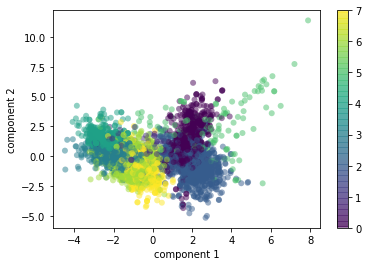

In [517]:
pca = PCA(n_components=5, random_state=RANDOM_SEED)
projected = pca.fit_transform(x_train)

dr_km = kmeans(n_clusters = 4, init = 'random', random_state = RANDOM_SEED)
dr_km.fit(projected)

dr_em = GMM(n_components = 8,  random_state = RANDOM_SEED)
dr_em.fit(projected)

dr_em_labels = dr_em.predict(projected)
dr_km_labels = dr_km.predict(projected)

plt.scatter(projected[:, 0], projected[:, 1],
            c=dr_em_labels, edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [132]:
def plot_model_complexity(grid_search_results, param_name):
    param = 'param_'+str(param_name)
    means_train = grid_search_results.groupby([param])['mean_train_score'].mean().reset_index()
    means_cv = grid_search_results.groupby([param])['mean_test_score'].mean().reset_index()
    means_train.sort_values(by=[param], inplace=True)
    means_cv.sort_values(by=[param], inplace=True)    
    param_values = list(means_train[param])
    
    plt.figure(figsize=(8, 8))
    plt.plot(param_values, means_train['mean_train_score'], 'r')
    plt.plot(param_values, means_cv['mean_test_score'], 'b')
    plt.title(param_name + " vs F1 Score")
    plt.xlabel(param_name)
    plt.ylabel('F1 Score')
    plt.ylim(means_cv['mean_test_score'].min()-0.1)
    plt.legend()
    plt.show()

#http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring ='f1', random_state = RANDOM_SEED)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [580]:
parameters = {'alpha':[0.01], 'hidden_layer_sizes':[128]
              ,'learning_rate_init':[0.00001],'activation':['relu']
            , 'solver':['lbfgs'], 'max_iter':[500]}

nn = MLPClassifier(verbose =1)
nn_model = GridSearchCV(nn, parameters, cv= 3, scoring = 'f1')
nn_model.fit(x_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=1, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.01], 'hidden_layer_sizes': [128], 'learning_rate_init': [1e-05], 'activation': ['relu'], 'solver': ['lbfgs'], 'max_iter': [500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

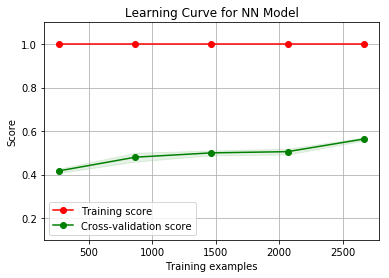

In [582]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
plot_learning_curve(MLPClassifier(alpha=0.00001,learning_rate_init=0.01,hidden_layer_sizes=128
                                  ,activation='relu',solver='lbfgs',max_iter = 500, verbose=True)
                                  ,"Learning Curve for NN Model"
                    , x_train, y_train, (0.1, 1.1), cv=cv, n_jobs=1)
plt.show()

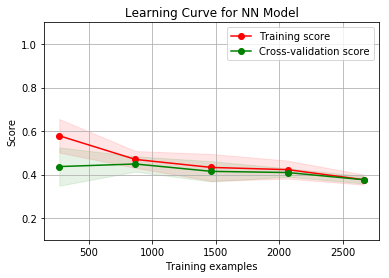

In [80]:
nn_model = MLPClassifier(alpha=0.00001,learning_rate_init=0.01,hidden_layer_sizes=128
                                  ,activation='relu',solver='lbfgs',max_iter = 500, verbose=True)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
plot_learning_curve(nn_model,"Learning Curve for NN Model", lda_projection, y_train, (0.1, 1.1), cv=cv, n_jobs=1)
plt.show()

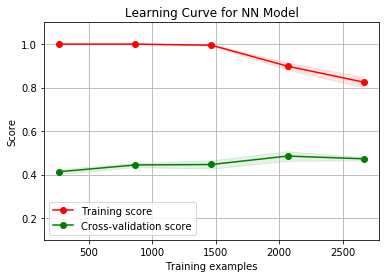

In [602]:
pca = PCA(n_components=5, random_state=RANDOM_SEED)
projected = pca.fit_transform(x_train)

nn_model = MLPClassifier(alpha=0.00001,learning_rate_init=0.01,hidden_layer_sizes=128
                                  ,activation='relu',solver='lbfgs',max_iter = 500, verbose=True)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
plot_learning_curve(nn_model,"Learning Curve for NN Model", projected, y_train, (0.1, 1.1), cv=cv, n_jobs=1)
plt.show()

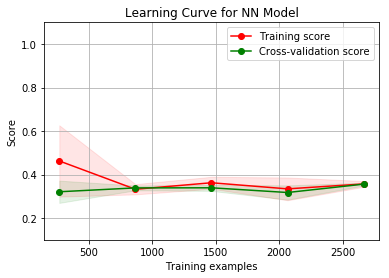

In [601]:
dr = FastICA(n_components=5, random_state=RANDOM_SEED)
projected = dr.fit_transform(x_train)

nn_model = MLPClassifier(alpha=0.00001,learning_rate_init=0.01,hidden_layer_sizes=128
                                  ,activation='relu',solver='lbfgs',max_iter = 500, verbose=True)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
plot_learning_curve(nn_model,"Learning Curve for NN Model", projected, y_train, (0.1, 1.1), cv=cv, n_jobs=1)
plt.show()

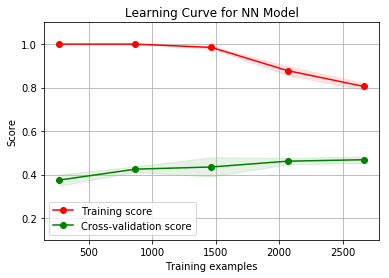

In [600]:
rp = SparseRandomProjection(random_state=RANDOM_SEED, n_components = 5)
projected = pd.DataFrame(rp.fit_transform(x_train))

nn_model = MLPClassifier(alpha=0.00001,learning_rate_init=0.01,hidden_layer_sizes=128
                                  ,activation='relu',solver='lbfgs',max_iter = 500, verbose=True)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
plot_learning_curve(nn_model,"Learning Curve for NN Model", projected, y_train, (0.1, 1.1), cv=cv, n_jobs=1)
plt.show()

In [20]:
nn_km = kmeans(n_clusters = 4, init = 'random', random_state = RANDOM_SEED)
nn_km.fit(x_train)

nn_em = GMM(n_components = 8,  random_state = RANDOM_SEED)
nn_em.fit(x_train)

##convert to percentages
nn_em_labels = nn_em.predict(x_train)
nn_km_labels = nn_km.predict(x_train)
nn_em_labels = pd.get_dummies(nn_em_labels)
nn_km_labels = pd.get_dummies(nn_km_labels)

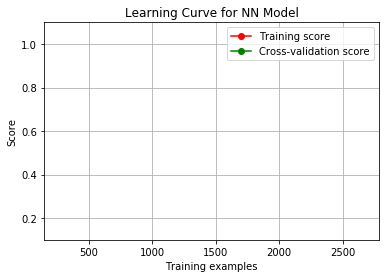

In [612]:
nn_model_em = MLPClassifier(alpha=0.00001,learning_rate_init=0.01,hidden_layer_sizes=128
                                  ,activation='relu',solver='lbfgs',max_iter = 500, verbose=True)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
plot_learning_curve(nn_model_em,"Learning Curve for NN Model", mn_em_labels, y_train, (0.1, 1.1), cv=cv, n_jobs=1)
plt.show()

Iteration 1, loss = 0.76371699
Iteration 2, loss = 0.62329219
Iteration 3, loss = 0.52826615
Iteration 4, loss = 0.48174729
Iteration 5, loss = 0.47008850
Iteration 6, loss = 0.46788109
Iteration 7, loss = 0.46740129
Iteration 8, loss = 0.45797382
Iteration 9, loss = 0.44438994
Iteration 10, loss = 0.43346746
Iteration 11, loss = 0.42435320
Iteration 12, loss = 0.42074691
Iteration 13, loss = 0.41989241
Iteration 14, loss = 0.41964952
Iteration 15, loss = 0.41976342
Iteration 16, loss = 0.42002039
Iteration 17, loss = 0.41942168
Iteration 18, loss = 0.41814471
Iteration 19, loss = 0.41629970
Iteration 20, loss = 0.41462729
Iteration 21, loss = 0.41336467
Iteration 22, loss = 0.41325992
Iteration 23, loss = 0.41352833
Iteration 24, loss = 0.41463211
Iteration 25, loss = 0.41451887
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.64381414
Iteration 2, loss = 0.50404273
Iteration 3, loss = 0.50175807
Iteration 4, loss = 0.481

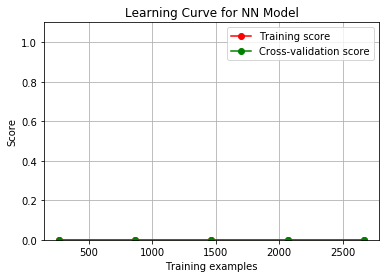

In [641]:
nn_model_km = MLPClassifier(alpha=0.0001,learning_rate_init=0.01,hidden_layer_sizes=128
                                  ,activation='relu',solver='adam',max_iter = 500, verbose=True)
cv = StratifiedKFold(n_splits=3, shuffle=True)
plot_learning_curve(nn_model_km,"Learning Curve for NN Model", nn_km_labels, y_train, (0.0, 1.1), cv=cv, n_jobs=1)
plt.show()

In [629]:
nn_em_labels_test = pd.get_dummies(nn_em.predict(x_test))
nn_km_labels_test = pd.get_dummies(nn_km.predict(x_test))

In [86]:
nn_km_labels_test = pd.get_dummies(nn_km.predict(x_test))
nn_model_km = MLPClassifier(alpha=0.01,learning_rate_init=0.01,hidden_layer_sizes=128
                                  ,activation='relu',solver='lbfgs',max_iter = 1000, verbose=True)

nn_model_km.fit(nn_km_labels, y_train)

preds = nn_model_km.predict(nn_km_labels_test)

accuracy_score(preds, y_test)

0.8178571428571428

In [624]:
param = 'param_'+str(param_name)
means_train = grid_search_results.groupby([param])['mean_train_score'].mean().reset_index()
means_cv = grid_search_results.groupby([param])['mean_test_score'].mean().reset_index()
means_train.sort_values(by=[param], inplace=True)
means_cv.sort_values(by=[param], inplace=True)    
param_values = list(means_train[param])

plt.figure(figsize=(8, 8))
plt.plot(param_values, means_train['mean_train_score'], 'r')
plt.plot(param_values, means_cv['mean_test_score'], 'b')
plt.title(param_name + " vs F1 Score")
plt.xlabel(param_name)
plt.ylabel('F1 Score')
plt.ylim(means_cv['mean_test_score'].min()-0.1)
plt.legend()
plt.show()

0.8457142857142858

In [15]:
epochs = [10,20,30,40,50,60,70,80,90,100,125,150,175,200,250,300,350,400,450,500]
print(epochs)
parameters = {'alpha':[0.01], 'hidden_layer_sizes':[128]
              ,'learning_rate_init':[0.01],'activation':['relu']
            , 'solver':['adam'], 'max_iter':epochs}

nn = MLPClassifier(verbose =1)
nn_model = GridSearchCV(nn, parameters, cv= 3, scoring = 'f1')
nn_model.fit(x_train, y_train)

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175, 200, 250, 300, 350, 400, 450, 500]
Iteration 1, loss = 0.47391427
Iteration 2, loss = 0.39249548
Iteration 3, loss = 0.37946899
Iteration 4, loss = 0.37182874
Iteration 5, loss = 0.37041130
Iteration 6, loss = 0.36628367
Iteration 7, loss = 0.36185031
Iteration 8, loss = 0.35902191
Iteration 9, loss = 0.35729211
Iteration 10, loss = 0.35286273
Iteration 1, loss = 0.49055228
Iteration 2, loss = 0.40472624
Iteration 3, loss = 0.39238475
Iteration 4, loss = 0.38523044
Iteration 5, loss = 0.37767898
Iteration 6, loss = 0.37330811
Iteration 7, loss = 0.37153847
Iteration 8, loss = 0.36927784
Iteration 9, loss = 0.36469470
Iteration 10, loss = 0.36873678
Iteration 1, loss = 0.48921521
Iteration 2, loss = 0.39549163
Iteration 3, loss = 0.38073409
Iteration 4, loss = 0.37407726
Iteration 5, loss = 0.36963656
Iteration 6, loss = 0.36454278
Iteration 7, loss = 0.35935054
Iteration 8, loss = 0.35785055
Iteration 9, loss = 0.35740653
Iterati

Iteration 23, loss = 0.32330078
Iteration 24, loss = 0.31772237
Iteration 25, loss = 0.31171745
Iteration 26, loss = 0.31182081
Iteration 27, loss = 0.30612373
Iteration 28, loss = 0.30983507
Iteration 29, loss = 0.31171678
Iteration 30, loss = 0.30519137
Iteration 31, loss = 0.30452923
Iteration 32, loss = 0.30210677
Iteration 33, loss = 0.29980823
Iteration 34, loss = 0.29282696
Iteration 35, loss = 0.29063649
Iteration 36, loss = 0.28979498
Iteration 37, loss = 0.28717280
Iteration 38, loss = 0.29012089
Iteration 39, loss = 0.30017057
Iteration 40, loss = 0.29074517
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.46410112
Iteration 2, loss = 0.39971710
Iteration 3, loss = 0.38876230
Iteration 4, loss = 0.38513390
Iteration 5, loss = 0.37738798
Iteration 6, loss = 0.37451302
Iteration 7, loss = 0.36771047
Iteration 8, loss = 0.36345917
Iteration 9, loss = 0.36119005
Iteration 10, loss = 0.35886136
Iteration 11, loss = 0

Iteration 20, loss = 0.32414521
Iteration 21, loss = 0.32187159
Iteration 22, loss = 0.32227631
Iteration 23, loss = 0.31949614
Iteration 24, loss = 0.31887580
Iteration 25, loss = 0.31648614
Iteration 26, loss = 0.31327432
Iteration 27, loss = 0.30957833
Iteration 28, loss = 0.31242206
Iteration 29, loss = 0.31638709
Iteration 30, loss = 0.31759432
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.47255080
Iteration 2, loss = 0.39815629
Iteration 3, loss = 0.38396771
Iteration 4, loss = 0.37138586
Iteration 5, loss = 0.36681921
Iteration 6, loss = 0.36704297
Iteration 7, loss = 0.36053431
Iteration 8, loss = 0.35604016
Iteration 9, loss = 0.35431696
Iteration 10, loss = 0.35187490
Iteration 11, loss = 0.35197719
Iteration 12, loss = 0.35149063
Iteration 13, loss = 0.34684561
Iteration 14, loss = 0.34825493
Iteration 15, loss = 0.34105166
Iteration 16, loss = 0.34244998
Iteration 17, loss = 0.33969657
Iteration 18, loss = 0

Iteration 49, loss = 0.29354809
Iteration 50, loss = 0.29756911
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.47780104
Iteration 2, loss = 0.39952799
Iteration 3, loss = 0.37956830
Iteration 4, loss = 0.37326016
Iteration 5, loss = 0.37058805
Iteration 6, loss = 0.36535030
Iteration 7, loss = 0.36145057
Iteration 8, loss = 0.36658599
Iteration 9, loss = 0.35416615
Iteration 10, loss = 0.35449532
Iteration 11, loss = 0.34822519
Iteration 12, loss = 0.34772630
Iteration 13, loss = 0.34463851
Iteration 14, loss = 0.34772590
Iteration 15, loss = 0.34431880
Iteration 16, loss = 0.34130919
Iteration 17, loss = 0.33686587
Iteration 18, loss = 0.33408761
Iteration 19, loss = 0.33269086
Iteration 20, loss = 0.32765804
Iteration 21, loss = 0.33108996
Iteration 22, loss = 0.32628103
Iteration 23, loss = 0.32574295
Iteration 24, loss = 0.32046025
Iteration 25, loss = 0.32032690
Iteration 26, loss = 0.32432553
Iteration 27, loss = 0

Iteration 25, loss = 0.32315892
Iteration 26, loss = 0.31626340
Iteration 27, loss = 0.31960661
Iteration 28, loss = 0.31083768
Iteration 29, loss = 0.31625259
Iteration 30, loss = 0.32824404
Iteration 31, loss = 0.34464825
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.45253055
Iteration 2, loss = 0.38552100
Iteration 3, loss = 0.37658413
Iteration 4, loss = 0.36878817
Iteration 5, loss = 0.36827290
Iteration 6, loss = 0.36047707
Iteration 7, loss = 0.36180838
Iteration 8, loss = 0.35462630
Iteration 9, loss = 0.35381620
Iteration 10, loss = 0.35564300
Iteration 11, loss = 0.34737453
Iteration 12, loss = 0.34213021
Iteration 13, loss = 0.33999186
Iteration 14, loss = 0.33947401
Iteration 15, loss = 0.33065431
Iteration 16, loss = 0.33655600
Iteration 17, loss = 0.33482637
Iteration 18, loss = 0.33337119
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.47453

Iteration 15, loss = 0.33338277
Iteration 16, loss = 0.34343288
Iteration 17, loss = 0.33193380
Iteration 18, loss = 0.33436885
Iteration 19, loss = 0.32947098
Iteration 20, loss = 0.32522585
Iteration 21, loss = 0.32495669
Iteration 22, loss = 0.32160436
Iteration 23, loss = 0.32668546
Iteration 24, loss = 0.31577698
Iteration 25, loss = 0.31885105
Iteration 26, loss = 0.31364749
Iteration 27, loss = 0.31119918
Iteration 28, loss = 0.31011690
Iteration 29, loss = 0.30753219
Iteration 30, loss = 0.30817617
Iteration 31, loss = 0.30404754
Iteration 32, loss = 0.30398319
Iteration 33, loss = 0.30418046
Iteration 34, loss = 0.29915809
Iteration 35, loss = 0.29229610
Iteration 36, loss = 0.29792028
Iteration 37, loss = 0.29140740
Iteration 38, loss = 0.28558356
Iteration 39, loss = 0.28468022
Iteration 40, loss = 0.29107806
Iteration 41, loss = 0.28969430
Iteration 42, loss = 0.28950966
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, 

Iteration 13, loss = 0.34439394
Iteration 14, loss = 0.34024245
Iteration 15, loss = 0.33368763
Iteration 16, loss = 0.33302482
Iteration 17, loss = 0.33169157
Iteration 18, loss = 0.32772324
Iteration 19, loss = 0.32493950
Iteration 20, loss = 0.32607514
Iteration 21, loss = 0.32537217
Iteration 22, loss = 0.32179183
Iteration 23, loss = 0.31595649
Iteration 24, loss = 0.32144202
Iteration 25, loss = 0.32007699
Iteration 26, loss = 0.31838781
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.50187959
Iteration 2, loss = 0.41124910
Iteration 3, loss = 0.39206898
Iteration 4, loss = 0.38535563
Iteration 5, loss = 0.38335486
Iteration 6, loss = 0.37763085
Iteration 7, loss = 0.37487658
Iteration 8, loss = 0.36950032
Iteration 9, loss = 0.36577233
Iteration 10, loss = 0.36594426
Iteration 11, loss = 0.35763661
Iteration 12, loss = 0.35586037
Iteration 13, loss = 0.35420945
Iteration 14, loss = 0.34836838
Iteration 15, loss = 0

GridSearchCV(cv=3, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=1, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.01], 'hidden_layer_sizes': [128], 'learning_rate_init': [0.01], 'activation': ['relu'], 'solver': ['adam'], 'max_iter': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175, 200, 250, 300, 350, 400, 450, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

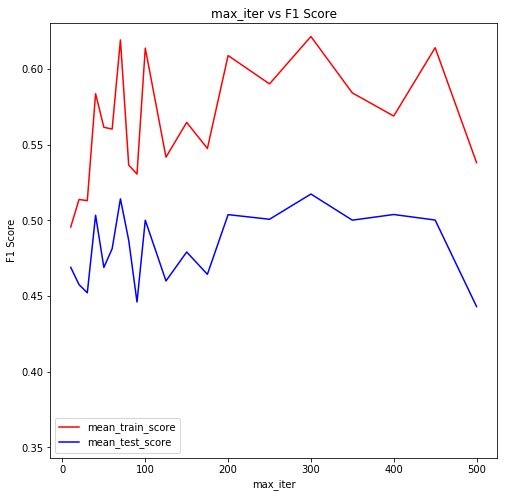

In [18]:
nn_model_grid_search_results = pd.DataFrame(nn_model.cv_results_).sort_values(by='rank_test_score')
plot_model_complexity(nn_model_grid_search_results, 'max_iter')

Iteration 1, loss = 0.55588243
Iteration 2, loss = 0.47250471
Iteration 3, loss = 0.46630700
Iteration 4, loss = 0.46532251
Iteration 5, loss = 0.46519501
Iteration 6, loss = 0.46498465
Iteration 7, loss = 0.46510877
Iteration 8, loss = 0.46573592
Iteration 9, loss = 0.46566551
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.50230283
Iteration 2, loss = 0.47360594
Iteration 3, loss = 0.47310058
Iteration 4, loss = 0.47206847
Iteration 5, loss = 0.47215258
Iteration 6, loss = 0.47217148
Iteration 7, loss = 0.47226050
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.54946441
Iteration 2, loss = 0.47412453
Iteration 3, loss = 0.47381878
Iteration 4, loss = 0.47125250
Iteration 5, loss = 0.47144924
Iteration 6, loss = 0.47138305
Iteration 7, loss = 0.47236040
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, l

Iteration 9, loss = 0.47204605
Iteration 10, loss = 0.47186045
Iteration 11, loss = 0.47180739
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.56071727
Iteration 2, loss = 0.47577516
Iteration 3, loss = 0.47356748
Iteration 4, loss = 0.47171477
Iteration 5, loss = 0.47133270
Iteration 6, loss = 0.47160430
Iteration 7, loss = 0.47229865
Iteration 8, loss = 0.47165170
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.50230402
Iteration 2, loss = 0.46870176
Iteration 3, loss = 0.46566209
Iteration 4, loss = 0.46575674
Iteration 5, loss = 0.46519630
Iteration 6, loss = 0.46510277
Iteration 7, loss = 0.46508199
Iteration 8, loss = 0.46546543
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.61359260
Iteration 2, loss = 0.48731360
Iteration 3, loss = 0.47295960
Iteration 4, loss = 0.47321377
Iteration 5,

Iteration 6, loss = 0.47267548
Iteration 7, loss = 0.47292533
Iteration 8, loss = 0.47207675
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.55006061
Iteration 2, loss = 0.47651715
Iteration 3, loss = 0.47317281
Iteration 4, loss = 0.47173301
Iteration 5, loss = 0.47204000
Iteration 6, loss = 0.47207993
Iteration 7, loss = 0.47229037
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.54397150
Iteration 2, loss = 0.46894186
Iteration 3, loss = 0.46720946
Iteration 4, loss = 0.46535131
Iteration 5, loss = 0.46673860
Iteration 6, loss = 0.46510973
Iteration 7, loss = 0.46614276
Iteration 8, loss = 0.46572945
Iteration 9, loss = 0.46527029
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.53595594
Iteration 2, loss = 0.47287357
Iteration 3, loss = 0.47364986
Iteration 4, loss = 0.47218184
Iteration 5, l

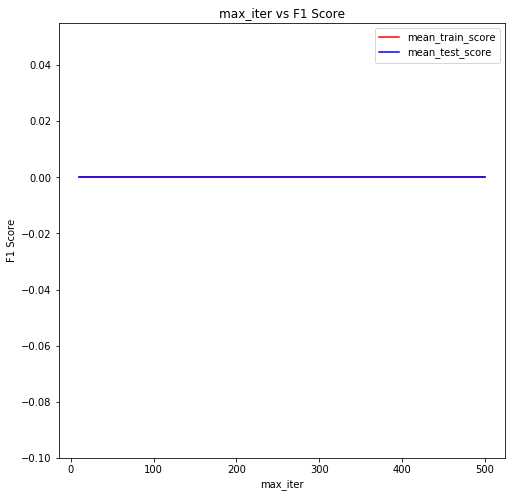

In [21]:
nn_model_k_means = GridSearchCV(nn, parameters, cv= 3, scoring = 'f1')
nn_model_k_means.fit(nn_km_labels, y_train)
k_means_grid_search_results = pd.DataFrame(nn_model_k_means.cv_results_).sort_values(by='rank_test_score')
plot_model_complexity(k_means_grid_search_results, 'max_iter')

Iteration 1, loss = 0.58190393
Iteration 2, loss = 0.47786879
Iteration 3, loss = 0.46442682
Iteration 4, loss = 0.46315837
Iteration 5, loss = 0.46321341
Iteration 6, loss = 0.46311984
Iteration 7, loss = 0.46309380
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.51867019
Iteration 2, loss = 0.47702340
Iteration 3, loss = 0.47279873
Iteration 4, loss = 0.47173860
Iteration 5, loss = 0.47237913
Iteration 6, loss = 0.47199550
Iteration 7, loss = 0.47225955
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.54184682
Iteration 2, loss = 0.47440304
Iteration 3, loss = 0.46936352
Iteration 4, loss = 0.46951801
Iteration 5, loss = 0.46938137
Iteration 6, loss = 0.46893983
Iteration 7, loss = 0.46925020
Iteration 8, loss = 0.46933644
Iteration 9, loss = 0.46961109
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, l

Iteration 6, loss = 0.47287684
Iteration 7, loss = 0.47326621
Iteration 8, loss = 0.47314706
Iteration 9, loss = 0.47237167
Iteration 10, loss = 0.47270892
Iteration 11, loss = 0.47290989
Iteration 12, loss = 0.47356197
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.52538922
Iteration 2, loss = 0.46945473
Iteration 3, loss = 0.47069639
Iteration 4, loss = 0.46960377
Iteration 5, loss = 0.47022025
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.50836793
Iteration 2, loss = 0.46752318
Iteration 3, loss = 0.46444783
Iteration 4, loss = 0.46354564
Iteration 5, loss = 0.46348943
Iteration 6, loss = 0.46314253
Iteration 7, loss = 0.46310762
Iteration 8, loss = 0.46399956
Iteration 9, loss = 0.46425141
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.51880676
Iteration 2, loss = 0.47623709
Iteration 3

Iteration 1, loss = 0.55394567
Iteration 2, loss = 0.48016792
Iteration 3, loss = 0.47117317
Iteration 4, loss = 0.46964314
Iteration 5, loss = 0.46973589
Iteration 6, loss = 0.46933114
Iteration 7, loss = 0.47019359
Iteration 8, loss = 0.46951535
Iteration 9, loss = 0.46967206
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.53789172
Iteration 2, loss = 0.46799801
Iteration 3, loss = 0.46415163
Iteration 4, loss = 0.46425539
Iteration 5, loss = 0.46288728
Iteration 6, loss = 0.46324440
Iteration 7, loss = 0.46476555
Iteration 8, loss = 0.46379114
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.53050850
Iteration 2, loss = 0.47356479
Iteration 3, loss = 0.47490488
Iteration 4, loss = 0.47323426
Iteration 5, loss = 0.47238907
Iteration 6, loss = 0.47304966
Iteration 7, loss = 0.47251518
Iteration 8, loss = 0.47297849
Training loss did not improve more than tol

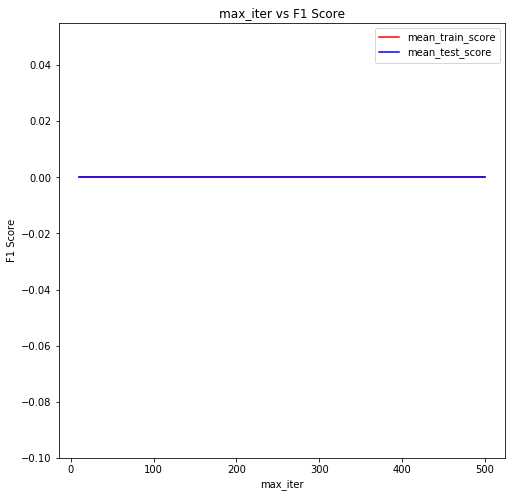

In [22]:
nn_model_em = GridSearchCV(nn, parameters, cv= 3, scoring = 'f1')
nn_model_em.fit(nn_em_labels, y_train)
em_grid_search_results = pd.DataFrame(nn_model_em.cv_results_).sort_values(by='rank_test_score')
plot_model_complexity(em_grid_search_results, 'max_iter')

In [138]:
#FOR EACH MODEL GET PERFORMANCE
nn_km_labels_test = pd.get_dummies(nn_km.predict(x_test))
nn_model_km = MLPClassifier(alpha=0.01,learning_rate_init=0.01,hidden_layer_sizes=128
                                  ,activation='relu',solver='lbfgs',max_iter = 1000, verbose=True
                            ,random_state=RANDOM_SEED)

nn_model_km.fit(nn_km_labels, y_train)

test_preds = nn_model_km.predict(nn_km_labels_test)
train_preds = nn_model_km.predict(nn_km_labels_test)

print(accuracy_score(preds, y_test))

0.8178571428571428


In [139]:
#FOR EACH MODEL GET PERFORMANCE
nn_model = MLPClassifier(alpha=0.01,learning_rate_init=0.01,hidden_layer_sizes=128
                                  ,activation='relu',solver='lbfgs',max_iter = 500, verbose=True
                        ,random_state = RANDOM_SEED)

In [141]:
nn_model.fit(x_train, y_train)

test_preds = nn_model.predict(x_test)
train_preds = nn_model.predict(x_train)

print('Test')
print(accuracy_score(test_preds, y_test))
print(f1_score(test_preds, y_test))
print(precision_score(test_preds, y_test))
print(recall_score(test_preds, y_test))

print('Train')
print(accuracy_score(train_preds, y_train))
print(f1_score(train_preds, y_train))
print(precision_score(train_preds, y_train))
print(recall_score(train_preds, y_train))

Test
0.8442857142857143
0.6021897810218979
0.6470588235294118
0.5631399317406144
Train
0.999
0.9975186104218362
0.9975186104218362
0.9975186104218362


In [100]:
pca = PCA(n_components=5, random_state=RANDOM_SEED)
projected_train = pca.fit_transform(x_train)
projected_test = pca.fit_transform(x_test)

nn_model.fit(projected_train, y_train)

train_preds = nn_model.predict(projected_train)
test_preds = nn_model.predict(projected_test)

print('Test')
print(accuracy_score(test_preds, y_test))
print(f1_score(test_preds, y_test))
print(precision_score(test_preds, y_test))
print(recall_score(test_preds, y_test))

print('Train')
print(accuracy_score(train_preds, y_train))
print(f1_score(train_preds, y_train))
print(precision_score(train_preds, y_train))
print(recall_score(train_preds, y_train))

Test
0.7957142857142857
0.42105263157894735
0.40784313725490196
0.4351464435146444
Train
0.90075
0.7406923579359895
0.7034739454094293
0.7820689655172414


In [108]:
pca = PCA(n_components=2, random_state=RANDOM_SEED)
projected_train = pca.fit_transform(x_train)
projected_test = pca.fit_transform(x_test)

nn_model.fit(projected_train, y_train)

train_preds = nn_model.predict(projected_train)
test_preds = nn_model.predict(projected_test)

print('Test')
print(accuracy_score(test_preds, y_test))
print(f1_score(test_preds, y_test))
print(precision_score(test_preds, y_test))
print(recall_score(test_preds, y_test))

print('Train')
print(accuracy_score(train_preds, y_train))
print(f1_score(train_preds, y_train))
print(precision_score(train_preds, y_train))
print(recall_score(train_preds, y_train))

Test
0.8235714285714286
0.1901639344262295
0.11372549019607843
0.58
Train
0.81025
0.24627606752730885
0.15384615384615385
0.6169154228855721


In [101]:
dr = FastICA(n_components=5, random_state=RANDOM_SEED)
projected_train = dr.fit_transform(x_train)
projected_test = dr.fit_transform(x_test)

nn_model.fit(projected_train, y_train)

train_preds = nn_model.predict(projected_train)
test_preds = nn_model.predict(projected_test)

print('Test')
print(accuracy_score(test_preds, y_test))
print(f1_score(test_preds, y_test))
print(precision_score(test_preds, y_test))
print(recall_score(test_preds, y_test))

print('Train')
print(accuracy_score(train_preds, y_train))
print(f1_score(train_preds, y_train))
print(precision_score(train_preds, y_train))
print(recall_score(train_preds, y_train))

Test
0.8007142857142857
0.4101479915433404
0.3803921568627451
0.44495412844036697
Train
0.8155
0.3503521126760563
0.24689826302729528
0.603030303030303


In [109]:
dr = SparseRandomProjection(n_components=2, random_state=RANDOM_SEED)
projected_train = dr.fit_transform(x_train)
projected_test = dr.fit_transform(x_test)

nn_model.fit(projected_train, y_train)

train_preds = nn_model.predict(projected_train)
test_preds = nn_model.predict(projected_test)

print('Test')
print(accuracy_score(test_preds, y_test))
print(f1_score(test_preds, y_test))
print(precision_score(test_preds, y_test))
print(recall_score(test_preds, y_test))

print('Train')
print(accuracy_score(train_preds, y_train))
print(f1_score(train_preds, y_train))
print(precision_score(train_preds, y_train))
print(recall_score(train_preds, y_train))

Test
0.8157142857142857
0.1103448275862069
0.06274509803921569
0.45714285714285713
Train
0.8095
0.16993464052287582
0.0967741935483871
0.6964285714285714


In [102]:
dr = SparseRandomProjection(n_components=5, random_state=RANDOM_SEED)
projected_train = dr.fit_transform(x_train)
projected_test = dr.fit_transform(x_test)

nn_model.fit(projected_train, y_train)

train_preds = nn_model.predict(projected_train)
test_preds = nn_model.predict(projected_test)

print('Test')
print(accuracy_score(test_preds, y_test))
print(f1_score(test_preds, y_test))
print(precision_score(test_preds, y_test))
print(recall_score(test_preds, y_test))

print('Train')
print(accuracy_score(train_preds, y_train))
print(f1_score(train_preds, y_train))
print(precision_score(train_preds, y_train))
print(recall_score(train_preds, y_train))

Test
0.82
0.4878048780487805
0.47058823529411764
0.5063291139240507
Train
0.89875
0.7204968944099379
0.6476426799007444
0.8118195956454122


In [105]:
dr = LinearDiscriminantAnalysis(n_components=5)
projected_train = dr.fit_transform(x_train,y_train)
projected_test = dr.fit_transform(x_test,y_test)

nn_model.fit(projected_train, y_train)

train_preds = nn_model.predict(projected_train)
test_preds = nn_model.predict(projected_test)

print('Test')
print(accuracy_score(test_preds, y_test))
print(f1_score(test_preds, y_test))
print(precision_score(test_preds, y_test))
print(recall_score(test_preds, y_test))

print('Train')
print(accuracy_score(train_preds, y_train))
print(f1_score(train_preds, y_train))
print(precision_score(train_preds, y_train))
print(recall_score(train_preds, y_train))

Test
0.8278571428571428
0.30945558739255014
0.21176470588235294
0.574468085106383
Train
0.82225
0.34710743801652894
0.23449131513647642
0.6678445229681979


In [112]:
dr_km = kmeans(n_clusters = 4, init = 'random', random_state = RANDOM_SEED)
dr_km.fit(x_train)

dr_km_labels_train = pd.get_dummies(dr_km.predict(x_train))
dr_km_labels_test = pd.get_dummies(dr_km.predict(x_test))

nn_model.fit(dr_km_labels_train, y_train)

test_preds = nn_model.predict(dr_km_labels_test)
train_preds = nn_model.predict(dr_km_labels_train)

print('Test')
print(accuracy_score(test_preds, y_test))
print(f1_score(test_preds, y_test))
print(precision_score(test_preds, y_test))
print(recall_score(test_preds, y_test))

print('Train')
print(accuracy_score(train_preds, y_train))
print(f1_score(train_preds, y_train))
print(precision_score(train_preds, y_train))
print(recall_score(train_preds, y_train))

Test
0.8178571428571428
0.0
0.0
0.0
Train
0.7985
0.0
0.0
0.0


In [120]:
dr_em = GMM(n_components = 8,  random_state = RANDOM_SEED)
dr_em.fit(x_train)

dr_em_labels_train =(dr_em.predict_proba(x_train))
dr_em_labels_test =(dr_em.predict_proba(x_test))

nn_model.fit(dr_em_labels_train, y_train)

test_preds = nn_model.predict(dr_em_labels_test)
train_preds = nn_model.predict(dr_em_labels_train)

print('Test')
print(accuracy_score(test_preds, y_test))
print(f1_score(test_preds, y_test))
print(precision_score(test_preds, y_test))
print(recall_score(test_preds, y_test))

print('Train')
print(accuracy_score(train_preds, y_train))
print(f1_score(train_preds, y_train))
print(precision_score(train_preds, y_train))
print(recall_score(train_preds, y_train))

Test
0.8157142857142857
0.058394160583941604
0.03137254901960784
0.42105263157894735
Train
0.7995
0.05868544600938967
0.031017369727047148
0.5434782608695652


In [142]:
dr_km = kmeans(n_clusters = 4, init = 'random', random_state = RANDOM_SEED)
dr_km.fit(x_train)

dr_km_labels_train = pd.get_dummies(dr_km.predict(x_train))
dr_km_labels_test = pd.get_dummies(dr_km.predict(x_test))

nn_model.fit(np.hstack((dr_km_labels_train,x_train)), y_train)

test_preds = nn_model.predict(np.hstack((dr_km_labels_test,x_test)))
train_preds = nn_model.predict(np.hstack((dr_km_labels_train,x_train)))

print('Test')
print(accuracy_score(test_preds, y_test))
print(f1_score(test_preds, y_test))
print(precision_score(test_preds, y_test))
print(recall_score(test_preds, y_test))

print('Train')
print(accuracy_score(train_preds, y_train))
print(f1_score(train_preds, y_train))
print(precision_score(train_preds, y_train))
print(recall_score(train_preds, y_train))

Test
0.8571428571428571
0.6309963099630995
0.6705882352941176
0.5958188153310104
Train
1.0
1.0
1.0
1.0


In [143]:
dr_em = GMM(n_components = 10,  random_state = RANDOM_SEED)
dr_em.fit(x_train)

dr_em_labels_train =(dr_em.predict_proba(x_train))
dr_em_labels_test =(dr_em.predict_proba(x_test))

nn_model.fit(np.hstack((dr_em_labels_train,x_train)), y_train)

test_preds = nn_model.predict(np.hstack((dr_em_labels_test,x_test)))
train_preds = nn_model.predict(np.hstack((dr_em_labels_train,x_train)))

print('Test')
print(accuracy_score(test_preds, y_test))
print(f1_score(test_preds, y_test))
print(precision_score(test_preds, y_test))
print(recall_score(test_preds, y_test))

print('Train')
print(accuracy_score(train_preds, y_train))
print(f1_score(train_preds, y_train))
print(precision_score(train_preds, y_train))
print(recall_score(train_preds, y_train))

Test
0.8542857142857143
0.6106870229007634
0.6274509803921569
0.5947955390334573
Train
1.0
1.0
1.0
1.0


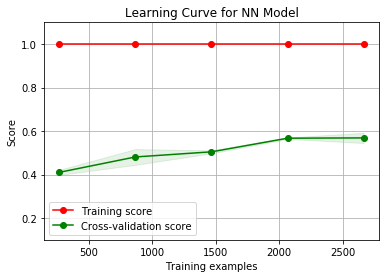

In [144]:
plot_learning_curve(nn_model,"Learning Curve for NN Model", np.hstack((dr_em_labels_train,x_train)), y_train, (0.1, 1.1), cv=cv, n_jobs=1)
plt.show()

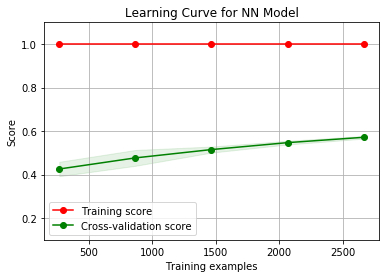

In [145]:
plot_learning_curve(nn_model,"Learning Curve for NN Model", np.hstack((dr_km_labels_train,x_train)), y_train, (0.1, 1.1), cv=cv, n_jobs=1)
plt.show()

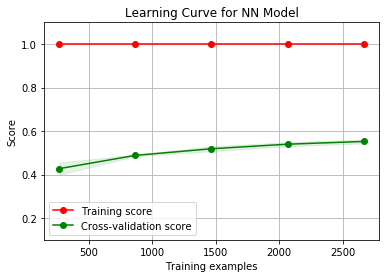

In [146]:
plot_learning_curve(nn_model,"Learning Curve for NN Model", x_train, y_train, (0.1, 1.1), cv=cv, n_jobs=1)
plt.show()